# 🚦 Akbank Derin Öğrenme Bootcamp: Yeni Nesil Proje Kampı

---

## 📋 Proje Özeti

Bu proje kapsamında, **CNN (Convolutional Neural Network)** mimarisi kullanarak bir derin öğrenme projesi geliştirilecektir. Katılımcılara, derin öğrenme alanında **görüntü sınıflandırması**, **veri analizi**, **model geliştirme**, **değerlendirme** ve **yorumlama** konularında pratik deneyim kazandırılması amaçlanmaktadır.

---

## 🎯 Proje Hedefleri

- ✅ **Görüntü Sınıflandırması**: CNN mimarisi ile trafik işaretlerini sınıflandırma
- ✅ **Veri Analizi**: Veri setinin detaylı analizi ve görselleştirme
- ✅ **Model Geliştirme**: Optimize edilmiş CNN modeli tasarımı
- ✅ **Değerlendirme**: Model performansının kapsamlı analizi
- ✅ **Yorumlama**: Sonuçların yorumlanması ve öneriler

---

## 📊 Dataset

- **Kaynak**: Kaggle - Hazır veri seti
- **Yol**: `/kaggle/input/traffic-signs-preprocessed`
- **Tür**: Trafik işaretleri görüntüleri
- **Boyut**: 32x32 piksel

---

## 🛠️ Teknolojiler

- **Python 3.x**
- **TensorFlow/Keras**
- **OpenCV**
- **Scikit-learn**
- **Matplotlib/Seaborn**
- **Plotly**


In [9]:
# 📚 Kütüphanelerin İçe Aktarılması
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

print("✅ Tüm kütüphaneler başarıyla yüklendi!")
print(f"TensorFlow versiyonu: {tf.__version__}")
print(f"Keras versiyonu: {keras.__version__}")


✅ Tüm kütüphaneler başarıyla yüklendi!
TensorFlow versiyonu: 2.18.0
Keras versiyonu: 3.8.0


In [10]:
# 📁 Dataset Yolu ve Veri Yükleme
dataset_path = "/kaggle/input/traffic-signs-preprocessed"
label_names_path = os.path.join(dataset_path, "label_names.csv")

# Dataset klasör yapısını kontrol et
if os.path.exists(dataset_path):
    print("✅ Dataset klasörü bulundu")
    
    # Label names dosyasını kontrol et
    if os.path.exists(label_names_path):
        print("✅ Label names dosyası bulundu")
        
        # Sınıf isimlerini yükle
        label_df = pd.read_csv(label_names_path)
        print(f"📊 CSV dosyası sütunları: {list(label_df.columns)}")
        print(f"📊 CSV dosyası boyutu: {label_df.shape}")
        
        # Sınıf isimlerini yükle
        class_names = label_df['SignName'].tolist()
        print(f"📊 {len(class_names)} sınıf ismi yüklendi")
        print("🏷️  İlk 10 sınıf:")
        for i in range(min(10, len(class_names))):
            print(f"   {i}: {class_names[i]}")
    else:
        print("❌ Label names dosyası bulunamadı!")
        class_names = None
    
    # Pickle dosyalarını kontrol et
    pickle_files = [f for f in os.listdir(dataset_path) if f.endswith('.pickle')]
    print(f"📊 Bulunan pickle dosyaları: {len(pickle_files)}")
    for file in pickle_files[:5]:  # İlk 5 dosyayı göster
        print(f"   - {file}")
    if len(pickle_files) > 5:
        print(f"   ... ve {len(pickle_files) - 5} dosya daha")
else:
    print("❌ Dataset klasörü bulunamadı!")
    class_names = None


✅ Dataset klasörü bulundu
✅ Label names dosyası bulundu
📊 CSV dosyası sütunları: ['ClassId', 'SignName']
📊 CSV dosyası boyutu: (43, 2)
📊 43 sınıf ismi yüklendi
🏷️  İlk 10 sınıf:
   0: Speed limit (20km/h)
   1: Speed limit (30km/h)
   2: Speed limit (50km/h)
   3: Speed limit (60km/h)
   4: Speed limit (70km/h)
   5: Speed limit (80km/h)
   6: End of speed limit (80km/h)
   7: Speed limit (100km/h)
   8: Speed limit (120km/h)
   9: No passing
📊 Bulunan pickle dosyaları: 17
   - mean_image_rgb.pickle
   - data5.pickle
   - data4.pickle
   - data7.pickle
   - data8.pickle
   ... ve 12 dosya daha


In [11]:
# 🎯 Pickle Dosyalarından Veri Yükleme ve %10'luk Örneklem Alma
import pickle

def load_data_from_pickle(dataset_path, sample_ratio=0.1, class_names=None):
    """
    Pickle dosyalarından veri yükler ve her sınıftan %10'luk örneklem alır
    
    Args:
        dataset_path (str): Dataset klasörü yolu
        sample_ratio (float): Örneklem oranı (0.1 = %10)
        class_names (list): Sınıf isimleri listesi
    
    Returns:
        tuple: (images, labels, class_names)
    """
    images = []
    labels = []
    
    print(f"🎯 Her sınıftan %{sample_ratio*100} örneklem alınacak")
    print("-" * 50)
    
    # Rastgelelik için seed belirleme
    np.random.seed(42)
    
    # Sadece train.pickle dosyasını yükle
    train_file = os.path.join(dataset_path, 'train.pickle')
    
    if not os.path.exists(train_file):
        print("❌ train.pickle dosyası bulunamadı!")
        return np.array([]), np.array([]), []
    
    print(f"🔄 train.pickle yükleniyor...")
    
    try:
        # Pickle dosyasını yükle
        with open(train_file, 'rb') as f:
            data = pickle.load(f)
        
        print(f"📊 Veri yapısı: {type(data)}")
        if isinstance(data, dict):
            print(f"📊 Anahtarlar: {list(data.keys())}")
        
        # Veri yapısını kontrol et ve uygun key'leri bul
        if isinstance(data, dict):
            # Olası key isimlerini kontrol et
            possible_image_keys = ['features', 'images', 'data', 'X']
            possible_label_keys = ['labels', 'y', 'targets']
            
            image_key = None
            label_key = None
            
            for key in possible_image_keys:
                if key in data:
                    image_key = key
                    break
            
            for key in possible_label_keys:
                if key in data:
                    label_key = key
                    break
            
            if image_key and label_key:
                class_images = data[image_key]
                class_labels = data[label_key]
                print(f"✅ Bulunan key'ler: {image_key}, {label_key}")
            else:
                print(f"❌ Uygun key'ler bulunamadı. Mevcut key'ler: {list(data.keys())}")
                return np.array([]), np.array([]), []
        
        elif isinstance(data, (list, tuple)) and len(data) == 2:
            # Tuple/list formatında ise (images, labels)
            class_images, class_labels = data
            print("✅ Tuple/list formatında veri bulundu")
        else:
            print(f"❌ Bilinmeyen veri formatı: {type(data)}")
            return np.array([]), np.array([]), []
        
        # Veri tiplerini kontrol et
        if not isinstance(class_images, np.ndarray):
            class_images = np.array(class_images)
        if not isinstance(class_labels, np.ndarray):
            class_labels = np.array(class_labels)
        
        print(f"📊 Görüntü boyutu: {class_images.shape}")
        print(f"📊 Label boyutu: {class_labels.shape}")
        
        # Her sınıftan %10'luk örneklem al
        unique_labels = np.unique(class_labels)
        print(f"📊 Toplam {len(unique_labels)} sınıf bulundu")
        
        for label in unique_labels:
            # Bu sınıfa ait tüm örnekleri bul
            label_indices = np.where(class_labels == label)[0]
            total_samples = len(label_indices)
            
            # Örneklem boyutunu hesapla
            sample_size = max(1, int(total_samples * sample_ratio))
            
            # Rastgele örneklem seç
            selected_indices = np.random.choice(label_indices, sample_size, replace=False)
            
            # Seçilen örnekleri ekle
            images.extend(class_images[selected_indices])
            labels.extend(class_labels[selected_indices])
            
            # Sınıf adını belirle
            if class_names and label < len(class_names):
                class_name = class_names[label]
            else:
                class_name = f"Sınıf_{label}"
            
            print(f"🏷️  {class_name}: {total_samples} → {sample_size} görüntü")
        
        # Sınıf isimlerini hazırla
        if class_names:
            loaded_class_names = class_names
        else:
            loaded_class_names = [f"Sınıf_{i}" for i in range(len(unique_labels))]
        
        return np.array(images), np.array(labels), loaded_class_names
        
    except Exception as e:
        print(f"❌ train.pickle yüklenirken hata: {str(e)}")
        return np.array([]), np.array([]), []

# Veriyi yükle (%10 örneklem)
print("🔄 Veri yükleniyor...")
images, labels, loaded_class_names = load_data_from_pickle(dataset_path, sample_ratio=0.1, class_names=class_names)

print(f"\n✅ Veri yükleme tamamlandı!")
print(f"📊 Toplam görüntü sayısı: {len(images)}")
print(f"🏷️  Toplam sınıf sayısı: {len(class_names)}")
print(f"🖼️  Görüntü boyutu: {images.shape[1:]}")

# Sınıf dağılımını göster
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\n📈 Sınıf dağılımı:")
for i, (label, count) in enumerate(zip(unique_labels, counts)):
    print(f"   {class_names[label]}: {count} görüntü")


🔄 Veri yükleniyor...
🎯 Her sınıftan %10.0 örneklem alınacak
--------------------------------------------------
🔄 train.pickle yükleniyor...
📊 Veri yapısı: <class 'dict'>
📊 Anahtarlar: ['coords', 'labels', 'features', 'sizes']
✅ Bulunan key'ler: features, labels
📊 Görüntü boyutu: (34799, 32, 32, 3)
📊 Label boyutu: (34799,)
📊 Toplam 43 sınıf bulundu
🏷️  Speed limit (20km/h): 180 → 18 görüntü
🏷️  Speed limit (30km/h): 1980 → 198 görüntü
🏷️  Speed limit (50km/h): 2010 → 201 görüntü
🏷️  Speed limit (60km/h): 1260 → 126 görüntü
🏷️  Speed limit (70km/h): 1770 → 177 görüntü
🏷️  Speed limit (80km/h): 1650 → 165 görüntü
🏷️  End of speed limit (80km/h): 360 → 36 görüntü
🏷️  Speed limit (100km/h): 1290 → 129 görüntü
🏷️  Speed limit (120km/h): 1260 → 126 görüntü
🏷️  No passing: 1320 → 132 görüntü
🏷️  No passing for vehicles over 3.5 metric tons: 1800 → 180 görüntü
🏷️  Right-of-way at the next intersection: 1170 → 117 görüntü
🏷️  Priority road: 1890 → 189 görüntü
🏷️  Yield: 1920 → 192 görüntü
🏷️  St

In [12]:
# 📊 Veri Özeti
print("✅ Veri yükleme tamamlandı!")
print(f"📊 Toplam görüntü sayısı: {len(images)}")
print(f"🏷️  Toplam sınıf sayısı: {len(loaded_class_names)}")
print(f"🖼️  Görüntü boyutu: {images.shape[1:]}")
print(f"🎯 Her sınıftan %10'luk kısmı kullanılıyor")

# Sınıf dağılımını göster
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\n📈 Sınıf dağılımı:")
for i, (label, count) in enumerate(zip(unique_labels, counts)):
    if label < len(loaded_class_names):
        print(f"   {loaded_class_names[label]}: {count} görüntü")
    else:
        print(f"   Sınıf_{label}: {count} görüntü")

# Veri tiplerini kontrol et
print(f"\n📊 Veri tipleri:")
print(f"   Images dtype: {images.dtype}")
print(f"   Images shape: {images.shape}")
print(f"   Labels dtype: {labels.dtype}")
print(f"   Labels shape: {labels.shape}")
print(f"   Min pixel value: {images.min()}")
print(f"   Max pixel value: {images.max()}")


✅ Veri yükleme tamamlandı!
📊 Toplam görüntü sayısı: 3479
🏷️  Toplam sınıf sayısı: 43
🖼️  Görüntü boyutu: (32, 32, 3)
🎯 Her sınıftan %10'luk kısmı kullanılıyor

📈 Sınıf dağılımı:
   Speed limit (20km/h): 18 görüntü
   Speed limit (30km/h): 198 görüntü
   Speed limit (50km/h): 201 görüntü
   Speed limit (60km/h): 126 görüntü
   Speed limit (70km/h): 177 görüntü
   Speed limit (80km/h): 165 görüntü
   End of speed limit (80km/h): 36 görüntü
   Speed limit (100km/h): 129 görüntü
   Speed limit (120km/h): 126 görüntü
   No passing: 132 görüntü
   No passing for vehicles over 3.5 metric tons: 180 görüntü
   Right-of-way at the next intersection: 117 görüntü
   Priority road: 189 görüntü
   Yield: 192 görüntü
   Stop: 69 görüntü
   No vehicles: 54 görüntü
   Vehicles over 3.5 metric tons prohibited: 36 görüntü
   No entry: 99 görüntü
   General caution: 108 görüntü
   Dangerous curve to the left: 18 görüntü
   Dangerous curve to the right: 30 görüntü
   Double curve: 27 görüntü
   Bumpy road:

# 📊 Veri Önişleme

Bu bölümde veri setini model eğitimi için hazırlayacağız:
- ✅ Veri formatını kontrol et ve uygun formata dönüştür
- ⏳ Train-validation-test setlerine ayır
- ⏳ Veri görselleştirmeleri ve istatistiksel analiz
- ⏳ Data Augmentation (Rotation, Flip, Zoom, Color Jitter)
- ⏳ Normalizasyon ve son kontroller

---

## 🔍 Adım 1: Veri Formatını Kontrol Et ve Uygun Formata Dönüştür

### 🎯 Amaç
Veri setinin formatını kontrol edip, derin öğrenme modelleri için uygun hale getirmek.

### 🔧 Yapılan İşlemler
1. **Veri Tipi Kontrolü**: Görüntülerin ve label'ların veri tiplerini kontrol ederiz
2. **Normalizasyon**: Pixel değerlerini 0-1 aralığına normalize ederiz (0-255'ten)
3. **Veri Tipi Dönüşümü**: Görüntüleri float32, label'ları int32'ye çeviririz
4. **Karıştırma**: Veri setini rastgele karıştırırız (shuffle)
5. **Kalite Kontrolü**: Sınıf dağılımını ve veri bütünlüğünü kontrol ederiz

### 📊 Beklenen Çıktı
- Görüntüler: (samples, 32, 32, 3) - float32 - [0.0, 1.0]
- Label'lar: (samples,) - int32 - [0, 42]
- Veri seti karıştırılmış ve model eğitimi için hazır


In [13]:
# 🔍 Veri Formatını Kontrol Et ve Uygun Formata Dönüştür
print("🔍 Veri formatı kontrol ediliyor...")
print(f"📊 Images shape: {images.shape}")
print(f"📊 Images dtype: {images.dtype}")
print(f"📊 Labels shape: {labels.shape}")
print(f"📊 Labels dtype: {labels.dtype}")
print(f"📊 Min pixel value: {images.min()}")
print(f"📊 Max pixel value: {images.max()}")

# Veri tiplerini kontrol et
print(f"\n📊 Veri tipleri kontrol ediliyor...")
print(f"   Images: {type(images)} - {images.dtype}")
print(f"   Labels: {type(labels)} - {labels.dtype}")

# Görüntü boyutlarını kontrol et
if len(images.shape) == 4:
    print(f"✅ Görüntüler 4D formatında: (samples, height, width, channels)")
    print(f"   Boyut: {images.shape[1]}x{images.shape[2]}x{images.shape[3]}")
else:
    print(f"⚠️  Beklenmeyen görüntü formatı: {images.shape}")

# Label'ları kontrol et
unique_labels = np.unique(labels)
print(f"✅ {len(unique_labels)} benzersiz sınıf bulundu")
print(f"   Label aralığı: {labels.min()} - {labels.max()}")

# Veri setinin boyutunu kontrol et
print(f"\n📊 Veri seti boyutu:")
print(f"   Toplam örnek sayısı: {len(images)}")
print(f"   Sınıf sayısı: {len(unique_labels)}")
print(f"   Her sınıf için ortalama örnek: {len(images) / len(unique_labels):.1f}")

# Bellek kullanımını kontrol et
memory_usage = images.nbytes / (1024 * 1024)  # MB cinsinden
print(f"   Bellek kullanımı: {memory_usage:.1f} MB")


🔍 Veri formatı kontrol ediliyor...
📊 Images shape: (3479, 32, 32, 3)
📊 Images dtype: uint8
📊 Labels shape: (3479,)
📊 Labels dtype: uint8
📊 Min pixel value: 0
📊 Max pixel value: 255

📊 Veri tipleri kontrol ediliyor...
   Images: <class 'numpy.ndarray'> - uint8
   Labels: <class 'numpy.ndarray'> - uint8
✅ Görüntüler 4D formatında: (samples, height, width, channels)
   Boyut: 32x32x3
✅ 43 benzersiz sınıf bulundu
   Label aralığı: 0 - 42

📊 Veri seti boyutu:
   Toplam örnek sayısı: 3479
   Sınıf sayısı: 43
   Her sınıf için ortalama örnek: 80.9
   Bellek kullanımı: 10.2 MB


In [14]:
# 🔄 Veri Formatını Uygun Hale Getir
print("🔄 Veri formatı uygun hale getiriliyor...")

# 1. Görüntüleri float32'ye çevir ve normalize et
if images.dtype != np.float32:
    images = images.astype(np.float32)
    print("✅ Görüntüler float32'ye çevrildi")

# 2. Pixel değerlerini 0-1 aralığına normalize et
if images.max() > 1.0:
    images = images / 255.0
    print("✅ Pixel değerleri 0-1 aralığına normalize edildi")
    print(f"   Yeni min değer: {images.min():.3f}")
    print(f"   Yeni max değer: {images.max():.3f}")

# 3. Label'ları int32'ye çevir
if labels.dtype != np.int32:
    labels = labels.astype(np.int32)
    print("✅ Label'lar int32'ye çevrildi")

# 4. Veri setini karıştır (shuffle)
print("🔄 Veri seti karıştırılıyor...")
indices = np.arange(len(images))
np.random.seed(42)
np.random.shuffle(indices)

images = images[indices]
labels = labels[indices]
print("✅ Veri seti karıştırıldı")

# 5. Son format kontrolü
print(f"\n✅ Veri formatı hazırlandı:")
print(f"   Images: {images.shape} - {images.dtype} - [{images.min():.3f}, {images.max():.3f}]")
print(f"   Labels: {labels.shape} - {labels.dtype} - [{labels.min()}, {labels.max()}]")

# 6. Sınıf dağılımını kontrol et
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\n📊 Sınıf dağılımı (ilk 10 sınıf):")
for i in range(min(10, len(unique_labels))):
    label = unique_labels[i]
    count = counts[i]
    if label < len(loaded_class_names):
        class_name = loaded_class_names[label]
    else:
        class_name = f"Sınıf_{label}"
    print(f"   {class_name}: {count} örnek")


🔄 Veri formatı uygun hale getiriliyor...
✅ Görüntüler float32'ye çevrildi
✅ Pixel değerleri 0-1 aralığına normalize edildi
   Yeni min değer: 0.000
   Yeni max değer: 1.000
✅ Label'lar int32'ye çevrildi
🔄 Veri seti karıştırılıyor...
✅ Veri seti karıştırıldı

✅ Veri formatı hazırlandı:
   Images: (3479, 32, 32, 3) - float32 - [0.000, 1.000]
   Labels: (3479,) - int32 - [0, 42]

📊 Sınıf dağılımı (ilk 10 sınıf):
   Speed limit (20km/h): 18 örnek
   Speed limit (30km/h): 198 örnek
   Speed limit (50km/h): 201 örnek
   Speed limit (60km/h): 126 örnek
   Speed limit (70km/h): 177 örnek
   Speed limit (80km/h): 165 örnek
   End of speed limit (80km/h): 36 örnek
   Speed limit (100km/h): 129 örnek
   Speed limit (120km/h): 126 örnek
   No passing: 132 örnek


## 🔄 Adım 2: Train-Validation-Test Setlerine Ayır

### 🎯 Amaç
Veri setini eğitim, doğrulama ve test olmak üzere üç ayrı sete bölmek.

### 🔧 Yapılan İşlemler
1. **Stratified Splitting**: Her sınıftan eşit oranda örnek alınmasını sağlarız
2. **İki Aşamalı Bölme**: 
   - İlk aşama: %80 (train+val) ve %20 (test)
   - İkinci aşama: %80'lik kısmı %60 (train) ve %20 (val) olarak böleriz
3. **One-Hot Encoding**: Label'ları kategorik formata çeviririz (43 sınıf için)
4. **Dağılım Kontrolü**: Her setteki sınıf dağılımını kontrol ederiz

### 📊 Veri Dağılımı
- **Train Seti**: %60 - Model eğitimi için
- **Validation Seti**: %20 - Model seçimi ve hiperparametre optimizasyonu için
- **Test Seti**: %20 - Final değerlendirme için

### ⚠️ Önemli Notlar
- Stratified splitting sayesinde her sette sınıf dengesi korunur
- One-hot encoding ile çok sınıflı sınıflandırma için uygun format elde edilir
- Random state (42) ile tekrarlanabilir sonuçlar sağlanır


In [15]:
# 🔄 Train-Validation-Test Setlerine Ayır
from sklearn.model_selection import train_test_split

print("🔄 Veri seti train-validation-test olarak ayrılıyor...")

# Önce train+validation ve test olarak ayır (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels
)

# Sonra train ve validation olarak ayır (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 0.25 * 0.8 = 0.2 (toplam verinin %20'si)
    random_state=42, 
    stratify=y_temp
)

print("✅ Veri seti başarıyla ayrıldı!")

# Set boyutlarını göster
print(f"\n📊 Veri seti boyutları:")
print(f"   Train seti: {X_train.shape[0]} örnek ({X_train.shape[0]/len(images)*100:.1f}%)")
print(f"   Validation seti: {X_val.shape[0]} örnek ({X_val.shape[0]/len(images)*100:.1f}%)")
print(f"   Test seti: {X_test.shape[0]} örnek ({X_test.shape[0]/len(images)*100:.1f}%)")
print(f"   Toplam: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} örnek")

# Her setteki sınıf dağılımını kontrol et
def check_class_distribution(y, set_name):
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"\n📊 {set_name} sınıf dağılımı:")
    print(f"   Sınıf sayısı: {len(unique_labels)}")
    print(f"   Min örnek: {counts.min()}")
    print(f"   Max örnek: {counts.max()}")
    print(f"   Ortalama: {counts.mean():.1f}")
    return unique_labels, counts

train_labels, train_counts = check_class_distribution(y_train, "Train")
val_labels, val_counts = check_class_distribution(y_val, "Validation")
test_labels, test_counts = check_class_distribution(y_test, "Test")


🔄 Veri seti train-validation-test olarak ayrılıyor...
✅ Veri seti başarıyla ayrıldı!

📊 Veri seti boyutları:
   Train seti: 2087 örnek (60.0%)
   Validation seti: 696 örnek (20.0%)
   Test seti: 696 örnek (20.0%)
   Toplam: 3479 örnek

📊 Train sınıf dağılımı:
   Sınıf sayısı: 43
   Min örnek: 11
   Max örnek: 121
   Ortalama: 48.5

📊 Validation sınıf dağılımı:
   Sınıf sayısı: 43
   Min örnek: 3
   Max örnek: 40
   Ortalama: 16.2

📊 Test sınıf dağılımı:
   Sınıf sayısı: 43
   Min örnek: 3
   Max örnek: 40
   Ortalama: 16.2


In [16]:
# 🏷️ Label'ları One-Hot Encoding'e Çevir
print("🏷️ Label'lar one-hot encoding'e çevriliyor...")

# Sınıf sayısını belirle
num_classes = len(np.unique(labels))
print(f"📊 Toplam sınıf sayısı: {num_classes}")

# One-hot encoding uygula
y_train_categorical = to_categorical(y_train, num_classes)
y_val_categorical = to_categorical(y_val, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

print("✅ One-hot encoding tamamlandı!")
print(f"   Train labels: {y_train_categorical.shape}")
print(f"   Validation labels: {y_val_categorical.shape}")
print(f"   Test labels: {y_test_categorical.shape}")

# Örnek one-hot encoding kontrolü
print(f"\n📊 One-hot encoding örneği:")
print(f"   Orijinal label: {y_train[0]}")
print(f"   One-hot: {y_train_categorical[0]}")
print(f"   Toplam: {y_train_categorical[0].sum()}")

# Veri setlerinin son durumunu özetle
print(f"\n✅ Veri setleri hazırlandı:")
print(f"   X_train: {X_train.shape} - {X_train.dtype}")
print(f"   y_train: {y_train_categorical.shape} - {y_train_categorical.dtype}")
print(f"   X_val: {X_val.shape} - {X_val.dtype}")
print(f"   y_val: {y_val_categorical.shape} - {y_val_categorical.dtype}")
print(f"   X_test: {X_test.shape} - {X_test.dtype}")
print(f"   y_test: {y_test_categorical.shape} - {y_test_categorical.dtype}")


🏷️ Label'lar one-hot encoding'e çevriliyor...
📊 Toplam sınıf sayısı: 43
✅ One-hot encoding tamamlandı!
   Train labels: (2087, 43)
   Validation labels: (696, 43)
   Test labels: (696, 43)

📊 One-hot encoding örneği:
   Orijinal label: 4
   One-hot: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Toplam: 1.0

✅ Veri setleri hazırlandı:
   X_train: (2087, 32, 32, 3) - float32
   y_train: (2087, 43) - float64
   X_val: (696, 32, 32, 3) - float32
   y_val: (696, 43) - float64
   X_test: (696, 32, 32, 3) - float32
   y_test: (696, 43) - float64


## 📊 Adım 3: Veri Görselleştirmeleri ve İstatistiksel Analiz

### 🎯 Amaç
Veri setini görsel ve istatistiksel olarak analiz etmek, veri kalitesini değerlendirmek.

### 🔧 Yapılan İşlemler
1. **Sınıf Dağılımı Histogramları**: Her setteki sınıf dağılımını görselleştiririz
2. **Veri Seti Dağılımı**: Train/val/test oranlarını pasta grafiği ile gösteririz
3. **Örnek Görüntüler**: Her setten rastgele örnekler gösteririz
4. **İstatistiksel Özet**: Detaylı sayısal analizler yaparız

### 📊 Görselleştirmeler
- **Histogramlar**: Sınıf başına örnek sayılarını gösterir
- **Pasta Grafiği**: Veri seti dağılımını gösterir
- **Örnek Görüntüler**: Veri kalitesini görsel olarak değerlendirir
- **İstatistikler**: Min/max/ortalama/std değerleri

### 📈 Analiz Metrikleri
- Toplam veri sayısı ve sınıf sayısı
- Her setteki örnek sayıları ve yüzdeleri
- Sınıf başına minimum/maksimum/ortalama örnek sayıları
- Pixel değerleri istatistikleri (min/max/ortalama/std)
- Bellek kullanımı hesaplaması


📊 Veri görselleştirmeleri hazırlanıyor...


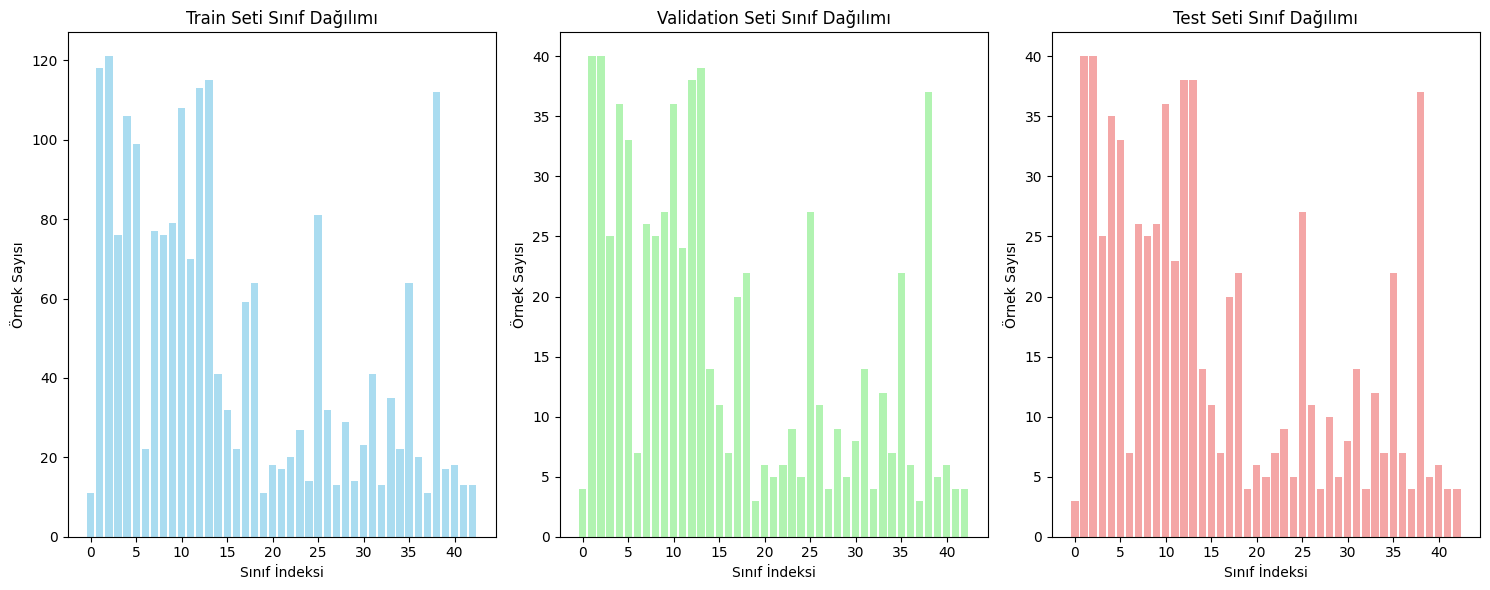

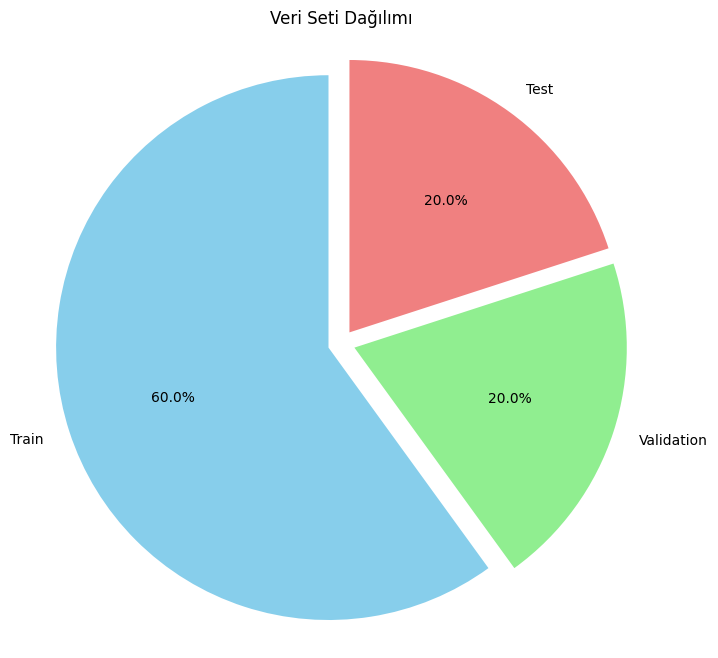

In [17]:
# 📊 Veri Görselleştirmeleri ve İstatistiksel Analiz
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib ayarları
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📊 Veri görselleştirmeleri hazırlanıyor...")

# 1. Sınıf dağılımı histogramı
plt.figure(figsize=(15, 6))

# Train seti sınıf dağılımı
plt.subplot(1, 3, 1)
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.bar(range(len(unique_labels)), counts, alpha=0.7, color='skyblue')
plt.title('Train Seti Sınıf Dağılımı')
plt.xlabel('Sınıf İndeksi')
plt.ylabel('Örnek Sayısı')
plt.xticks(range(0, len(unique_labels), 5))

# Validation seti sınıf dağılımı
plt.subplot(1, 3, 2)
unique_labels, counts = np.unique(y_val, return_counts=True)
plt.bar(range(len(unique_labels)), counts, alpha=0.7, color='lightgreen')
plt.title('Validation Seti Sınıf Dağılımı')
plt.xlabel('Sınıf İndeksi')
plt.ylabel('Örnek Sayısı')
plt.xticks(range(0, len(unique_labels), 5))

# Test seti sınıf dağılımı
plt.subplot(1, 3, 3)
unique_labels, counts = np.unique(y_test, return_counts=True)
plt.bar(range(len(unique_labels)), counts, alpha=0.7, color='lightcoral')
plt.title('Test Seti Sınıf Dağılımı')
plt.xlabel('Sınıf İndeksi')
plt.ylabel('Örnek Sayısı')
plt.xticks(range(0, len(unique_labels), 5))

plt.tight_layout()
plt.show()

# 2. Set boyutları pasta grafiği
plt.figure(figsize=(8, 8))
sizes = [X_train.shape[0], X_val.shape[0], X_test.shape[0]]
labels = ['Train', 'Validation', 'Test']
colors = ['skyblue', 'lightgreen', 'lightcoral']
explode = (0.05, 0.05, 0.05)

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
plt.title('Veri Seti Dağılımı')
plt.axis('equal')
plt.show()


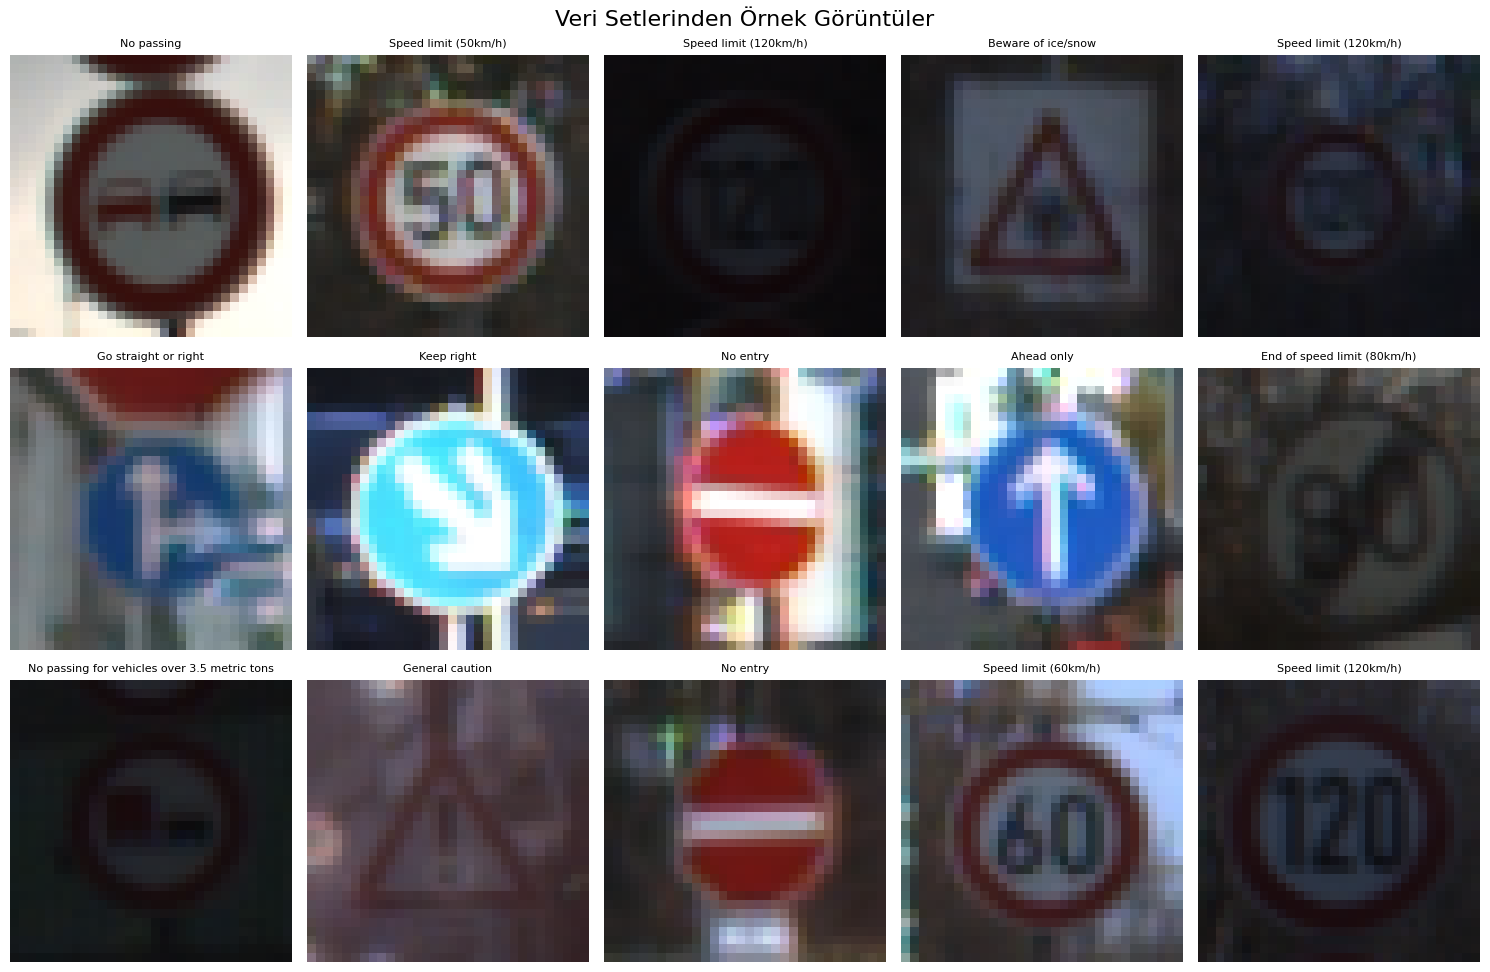


📊 İstatistiksel Özet:
Toplam veri sayısı: 3479
Sınıf sayısı: 43
Görüntü boyutu: (32, 32, 3)

Train Seti:
  Örnek sayısı: 2087
  Sınıf sayısı: 43
  Min örnek/sınıf: 11
  Max örnek/sınıf: 121
  Ortalama örnek/sınıf: 48.5
  Std örnek/sınıf: 37.0

Validation Seti:
  Örnek sayısı: 696
  Sınıf sayısı: 43
  Min örnek/sınıf: 3
  Max örnek/sınıf: 40
  Ortalama örnek/sınıf: 16.2
  Std örnek/sınıf: 12.5

Test Seti:
  Örnek sayısı: 696
  Sınıf sayısı: 43
  Min örnek/sınıf: 3
  Max örnek/sınıf: 40
  Ortalama örnek/sınıf: 16.2
  Std örnek/sınıf: 12.4

Pixel Değerleri İstatistikleri:
  Min değer: 0.000
  Max değer: 1.000
  Ortalama: 0.325
  Std: 0.266


In [18]:
# 3. Örnek görüntüleri göster
plt.figure(figsize=(15, 10))

# Her setten 5'er örnek göster
sets = [
    (X_train, y_train, 'Train Seti'),
    (X_val, y_val, 'Validation Seti'),
    (X_test, y_test, 'Test Seti')
]

for set_idx, (X_set, y_set, set_name) in enumerate(sets):
    for i in range(5):
        plt.subplot(3, 5, set_idx * 5 + i + 1)
        
        # Rastgele bir örnek seç
        idx = np.random.randint(0, len(X_set))
        image = X_set[idx]
        label = y_set[idx]
        
        # Görüntüyü göster
        plt.imshow(image)
        
        # Sınıf adını al
        if label < len(loaded_class_names):
            class_name = loaded_class_names[label]
        else:
            class_name = f"Sınıf_{label}"
        
        plt.title(f"{class_name}", fontsize=8)
        plt.axis('off')

plt.suptitle('Veri Setlerinden Örnek Görüntüler', fontsize=16)
plt.tight_layout()
plt.show()

# 4. İstatistiksel özet
print("\n📊 İstatistiksel Özet:")
print("=" * 50)

# Genel istatistikler
print(f"Toplam veri sayısı: {len(images)}")
print(f"Sınıf sayısı: {num_classes}")
print(f"Görüntü boyutu: {X_train.shape[1:]}")

# Her set için detaylı istatistikler
for set_name, X_set, y_set in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
    unique_labels, counts = np.unique(y_set, return_counts=True)
    print(f"\n{set_name} Seti:")
    print(f"  Örnek sayısı: {len(X_set)}")
    print(f"  Sınıf sayısı: {len(unique_labels)}")
    print(f"  Min örnek/sınıf: {counts.min()}")
    print(f"  Max örnek/sınıf: {counts.max()}")
    print(f"  Ortalama örnek/sınıf: {counts.mean():.1f}")
    print(f"  Std örnek/sınıf: {counts.std():.1f}")

# Pixel değerleri istatistikleri
print(f"\nPixel Değerleri İstatistikleri:")
print(f"  Min değer: {X_train.min():.3f}")
print(f"  Max değer: {X_train.max():.3f}")
print(f"  Ortalama: {X_train.mean():.3f}")
print(f"  Std: {X_train.std():.3f}")


## 🔄 Adım 4: Data Augmentation (Veri Çoğaltma)

### 🎯 Amaç
Mevcut veri setini çeşitli dönüşümlerle genişletmek, modelin genelleme yeteneğini artırmak.

### 🔧 Kullanılan Dönüşümler
1. **Rotation**: ±10° döndürme (trafik işaretleri için uygun)
2. **Shift**: ±5% genişlik/yükseklik kaydırma
3. **Shear**: ±5% kesme dönüşümü
4. **Zoom**: ±5% yakınlaştırma/uzaklaştırma
5. **Fill Mode**: Boşlukları 'nearest' ile doldurma


### 🔄 Augmentation Süreci
1. **ImageDataGenerator**: Keras'ın built-in augmentation aracı
2. **Batch Processing**: 100'lük batch'ler halinde işleme
3. **Real-time Generation**: Her epoch'ta farklı augmented görüntüler
4. **Factor 2**: Her orijinal görüntü için 2 augmented versiyon

### 📊 Sonuç
- Train seti 2x genişler (orijinal + augmented)
- Model daha robust hale gelir
- Overfitting riski azalır
- Genelleme yeteneği artar


🔄 Data Augmentation hazırlanıyor...
✅ Data Augmentation parametreleri ayarlandı:
   - Rotation: ±10° (azaltıldı)
   - Shift: ±10% (width/height) (azaltıldı)
   - Shear: ±10% (azaltıldı)
   - Zoom: ±10% (azaltıldı)
   - Brightness: Kaldırıldı (çok karanlık yapıyordu)
   - Channel shift: Kaldırıldı (renk bozulması)
   - Horizontal/Vertical flip: Kapalı (trafik işaretleri için uygun değil)

🔄 Data Augmentation train setine uygulanıyor...
📊 Augmented görüntü örnekleri hazırlanıyor...


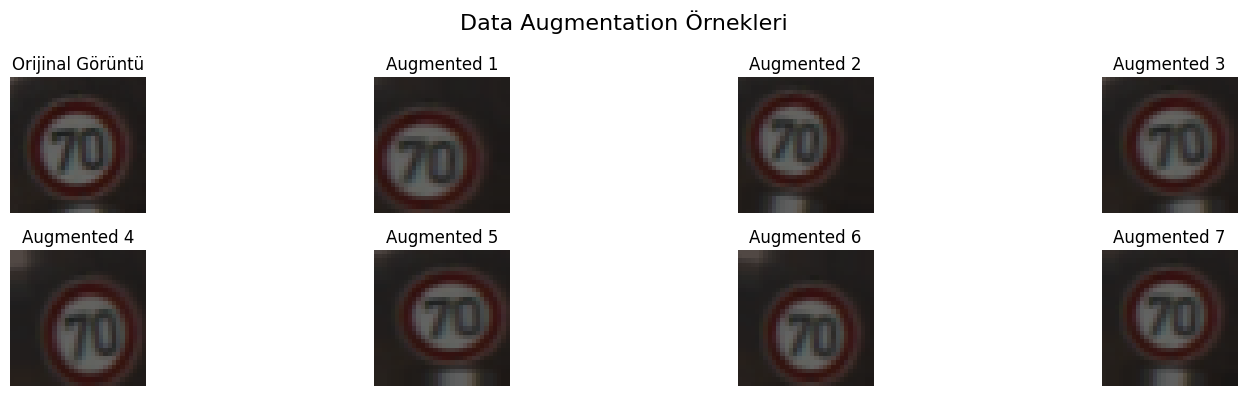

📊 Örnek sınıf: Speed limit (70km/h)
📊 Toplam 7 augmented görüntü oluşturuldu


In [19]:
# 🔄 Data Augmentation (Veri Çoğaltma)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("🔄 Data Augmentation hazırlanıyor...")

# Data Augmentation parametreleri
datagen = ImageDataGenerator(
    rotation_range=10,          # ±10 derece döndürme (azaltıldı)
    width_shift_range=0.1,     # %10 genişlik kaydırma (azaltıldı)
    height_shift_range=0.1,    # %10 yükseklik kaydırma (azaltıldı)
    shear_range=0.1,           # %10 kesme dönüşümü (azaltıldı)
    zoom_range=0.1,            # %10 yakınlaştırma (azaltıldı)
    horizontal_flip=False,       # Yatay çevirme (trafik işaretleri için uygun değil)
    vertical_flip=False,        # Dikey çevirme (trafik işaretleri için uygun değil)
    fill_mode='nearest'         # Boşlukları doldurma yöntemi
    # brightness_range kaldırıldı - çok karanlık yapıyordu
    # channel_shift_range kaldırıldı - renk bozulmasına neden oluyordu
)

print("✅ Data Augmentation parametreleri ayarlandı:")
print("   - Rotation: ±10° (azaltıldı)")
print("   - Shift: ±10% (width/height) (azaltıldı)")
print("   - Shear: ±10% (azaltıldı)")
print("   - Zoom: ±10% (azaltıldı)")
print("   - Brightness: Kaldırıldı (çok karanlık yapıyordu)")
print("   - Channel shift: Kaldırıldı (renk bozulması)")
print("   - Horizontal/Vertical flip: Kapalı (trafik işaretleri için uygun değil)")

# Data Augmentation'ı train setine uygula
print("\n🔄 Data Augmentation train setine uygulanıyor...")

# Fit işlemi (istatistikleri hesapla)
datagen.fit(X_train)

# Örnek augmented görüntüleri göster
print("📊 Augmented görüntü örnekleri hazırlanıyor...")

# Orijinal görüntü
original_image = X_train[0:1]  # Batch boyutu 1
original_label = y_train[0]

# Augmented görüntüleri oluştur
augmented_images = []
for i, aug_img in enumerate(datagen.flow(original_image, batch_size=1)):
    augmented_images.append(aug_img[0])
    if i >= 6:  # 7 tane augmented görüntü (toplam 8 görüntü)
        break

# Görselleştirme
plt.figure(figsize=(16, 4))

# Orijinal görüntü
plt.subplot(2, 4, 1)
# Orijinal görüntüyü de aynı şekilde göster
display_original = (np.clip(original_image[0], 0, 1) * 255).astype(np.uint8)
plt.imshow(display_original)
plt.title('Orijinal Görüntü', fontsize=12)
plt.axis('off')

# Augmented görüntüler
for i, aug_img in enumerate(augmented_images):
    plt.subplot(2, 4, i + 2)
    # Pixel değerlerini 0-255 aralığına çevir ve uint8'e dönüştür
    display_img = (np.clip(aug_img, 0, 1) * 255).astype(np.uint8)
    plt.imshow(display_img)
    plt.title(f'Augmented {i+1}', fontsize=12)
    plt.axis('off')

plt.suptitle('Data Augmentation Örnekleri', fontsize=16)
plt.tight_layout()
plt.show()

# Sınıf adını göster
if original_label < len(loaded_class_names):
    class_name = loaded_class_names[original_label]
else:
    class_name = f"Sınıf_{original_label}"

print(f"📊 Örnek sınıf: {class_name}")
print(f"📊 Toplam {len(augmented_images)} augmented görüntü oluşturuldu")


In [20]:
# 🔄 Data Augmentation ile Veri Seti Genişletme
print("🔄 Data Augmentation ile veri seti genişletiliyor...")

# Augmentation faktörü (her orijinal görüntü için kaç tane augmented oluşturulacak)
augmentation_factor = 2  # Her görüntü için 2 tane augmented

print(f"📊 Orijinal train seti: {X_train.shape[0]} örnek")
print(f"📊 Augmentation faktörü: {augmentation_factor}")

# Yeni veri setleri için listeler oluştur
X_train_augmented_list = []
y_train_augmented_list = []

# Orijinal verileri ekle
X_train_augmented_list.extend(X_train)
y_train_augmented_list.extend(y_train)

# Augmented verileri oluştur ve ekle
augmented_count = 0
for i in range(0, len(X_train), 100):  # 100'lük batch'ler
    batch_X = X_train[i:i+100]
    batch_y = y_train[i:i+100]
    
    # Bu batch için augmented veriler oluştur
    for j, (aug_X, aug_y) in enumerate(datagen.flow(batch_X, batch_y, batch_size=100, shuffle=False)):
        # Augmented görüntüleri hemen float32'ye çevir ve normalize et
        aug_X_processed = aug_X.astype(np.float32)
        
        # Her augmented görüntüyü tek tek ekle
        for k in range(len(aug_X_processed)):
            X_train_augmented_list.append(aug_X_processed[k])
            y_train_augmented_list.append(aug_y[k])  # Augmented label'ları kullan
        
        augmented_count += len(aug_X_processed)
        
        if j >= augmentation_factor - 1:  # Her orijinal için augmentation_factor kadar
            break
    
    if (i + 100) % 1000 == 0:
        print(f"   İşlenen: {i + 100}/{len(X_train)} örnek")

# Listeleri numpy array'e çevir
print("🔄 Listeler numpy array'e çevriliyor...")
print(f"   Liste boyutu: {len(X_train_augmented_list)}")
print(f"   İlk örnek boyutu: {X_train_augmented_list[0].shape}")
print(f"   İlk örnek dtype: {X_train_augmented_list[0].dtype}")

X_train_augmented = np.array(X_train_augmented_list)
y_train_augmented = np.array(y_train_augmented_list)

print(f"✅ Augmentation tamamlandı!")
print(f"📊 Yeni train seti boyutu: {X_train_augmented.shape[0]} örnek")
print(f"📊 Eklenen augmented örnek: {augmented_count}")
print(f"📊 Genişleme oranı: {X_train_augmented.shape[0] / X_train.shape[0]:.1f}x")

# Augmented veri setinin sınıf dağılımını kontrol et
unique_labels, counts = np.unique(y_train_augmented, return_counts=True)
print(f"\n📊 Augmented train seti sınıf dağılımı:")
print(f"   Sınıf sayısı: {len(unique_labels)}")
print(f"   Min örnek/sınıf: {counts.min()}")
print(f"   Max örnek/sınıf: {counts.max()}")
print(f"   Ortalama örnek/sınıf: {counts.mean():.1f}")

# Augmented veri setini kullan
X_train = X_train_augmented
y_train = y_train_augmented
y_train_categorical = to_categorical(y_train, num_classes)

print(f"\n✅ Veri seti güncellendi:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_train_categorical: {y_train_categorical.shape}")


🔄 Data Augmentation ile veri seti genişletiliyor...
📊 Orijinal train seti: 2087 örnek
📊 Augmentation faktörü: 2
   İşlenen: 1000/2087 örnek
   İşlenen: 2000/2087 örnek
🔄 Listeler numpy array'e çevriliyor...
   Liste boyutu: 6261
   İlk örnek boyutu: (32, 32, 3)
   İlk örnek dtype: float32
✅ Augmentation tamamlandı!
📊 Yeni train seti boyutu: 6261 örnek
📊 Eklenen augmented örnek: 4174
📊 Genişleme oranı: 3.0x

📊 Augmented train seti sınıf dağılımı:
   Sınıf sayısı: 43
   Min örnek/sınıf: 33
   Max örnek/sınıf: 363
   Ortalama örnek/sınıf: 145.6

✅ Veri seti güncellendi:
   X_train: (6261, 32, 32, 3)
   y_train: (6261,)
   y_train_categorical: (6261, 43)


## ✅ Adım 5: Normalizasyon ve Son Kontroller

### 🎯 Amaç
Veri önişleme sürecinin son kontrollerini yapmak, veri setinin model eğitimi için hazır olduğunu doğrulamak.

### 🔧 Yapılan Kontroller
1. **Veri Formatı Kontrolü**: Tüm setlerin boyut ve veri tipi kontrolü
2. **Sınıf Dağılımı**: Her setteki sınıf dengesini kontrol ederiz
3. **Pixel Değerleri**: Min/max/ortalama/std değerlerini kontrol ederiz
4. **Bellek Kullanımı**: Veri setinin bellek kullanımını hesaplarız
5. **Veri Kalitesi**: NaN, Inf değerleri ve label tutarlılığını kontrol ederiz

### 📊 Kontrol Metrikleri
- **Boyut Kontrolü**: Tüm setlerin tutarlı boyutlarda olduğunu doğrular
- **Veri Tipi**: float32 (görüntüler) ve int32 (label'lar) kontrolü
- **Pixel Aralığı**: [0.0, 1.0] aralığında normalize edildiğini doğrular
- **Sınıf Dengesi**: Her sette tüm sınıfların mevcut olduğunu kontrol eder
- **Bellek Verimliliği**: Toplam bellek kullanımını hesaplar

### ✅ Başarı Kriterleri
- Tüm setler aynı format ve boyutta
- Hiç NaN veya Inf değer yok
- Label'lar tutarlı (one-hot encoding doğru)
- Sınıf dağılımı dengeli
- Bellek kullanımı makul seviyede

### 🎯 Sonuç
Veri seti model eğitimi için tamamen hazır durumda!


In [21]:
# ✅ Normalizasyon ve Son Kontroller
print("✅ Veri önişleme son kontrolleri yapılıyor...")

# 1. Veri setlerinin son durumunu kontrol et
print("\n📊 Veri setleri son durumu:")
print("=" * 50)

sets_info = [
    ("Train", X_train, y_train_categorical),
    ("Validation", X_val, y_val_categorical),
    ("Test", X_test, y_test_categorical)
]

for set_name, X_set, y_set in sets_info:
    print(f"\n{set_name} Seti:")
    print(f"  Görüntüler: {X_set.shape} - {X_set.dtype}")
    print(f"  Label'lar: {y_set.shape} - {y_set.dtype}")
    print(f"  Min pixel: {X_set.min():.3f}")
    print(f"  Max pixel: {X_set.max():.3f}")
    print(f"  Ortalama pixel: {X_set.mean():.3f}")
    print(f"  Std pixel: {X_set.std():.3f}")

# 2. Sınıf dağılımını kontrol et
print(f"\n📊 Sınıf dağılımı kontrolü:")
for set_name, X_set, y_set in sets_info:
    if set_name == "Train":
        # Train seti için orijinal label'ları kullan
        unique_labels, counts = np.unique(y_train, return_counts=True)
    else:
        # Val ve test setleri için categorical'den orijinal label'ları çıkar
        original_labels = np.argmax(y_set, axis=1)
        unique_labels, counts = np.unique(original_labels, return_counts=True)
    
    print(f"  {set_name}: {len(unique_labels)} sınıf, {counts.min()}-{counts.max()} örnek/sınıf")

# 3. Veri seti boyutlarını özetle
total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
print(f"\n📊 Toplam veri seti özeti:")
print(f"  Toplam örnek: {total_samples}")
print(f"  Train: {X_train.shape[0]} ({X_train.shape[0]/total_samples*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} ({X_val.shape[0]/total_samples*100:.1f}%)")
print(f"  Test: {X_test.shape[0]} ({X_test.shape[0]/total_samples*100:.1f}%)")
print(f"  Sınıf sayısı: {num_classes}")
print(f"  Görüntü boyutu: {X_train.shape[1:]}")

# 4. Bellek kullanımını hesapla
train_memory = X_train.nbytes / (1024 * 1024)
val_memory = X_val.nbytes / (1024 * 1024)
test_memory = X_test.nbytes / (1024 * 1024)
total_memory = train_memory + val_memory + test_memory

print(f"\n💾 Bellek kullanımı:")
print(f"  Train: {train_memory:.1f} MB")
print(f"  Validation: {val_memory:.1f} MB")
print(f"  Test: {test_memory:.1f} MB")
print(f"  Toplam: {total_memory:.1f} MB")

# 5. Veri kalitesi kontrolü
print(f"\n🔍 Veri kalitesi kontrolü:")

# NaN değer kontrolü
train_nan = np.isnan(X_train).sum()
val_nan = np.isnan(X_val).sum()
test_nan = np.isnan(X_test).sum()

print(f"  NaN değerler - Train: {train_nan}, Val: {val_nan}, Test: {test_nan}")

# Inf değer kontrolü
train_inf = np.isinf(X_train).sum()
val_inf = np.isinf(X_val).sum()
test_inf = np.isinf(X_test).sum()

print(f"  Inf değerler - Train: {train_inf}, Val: {val_inf}, Test: {test_inf}")

# Label tutarlılığı kontrolü
train_labels_ok = (y_train_categorical.sum(axis=1) == 1).all()
val_labels_ok = (y_val_categorical.sum(axis=1) == 1).all()
test_labels_ok = (y_test_categorical.sum(axis=1) == 1).all()

print(f"  Label tutarlılığı - Train: {train_labels_ok}, Val: {val_labels_ok}, Test: {test_labels_ok}")

print(f"\n✅ Veri önişleme tamamlandı!")
print(f"🎯 Veri seti model eğitimi için hazır!")


✅ Veri önişleme son kontrolleri yapılıyor...

📊 Veri setleri son durumu:

Train Seti:
  Görüntüler: (6261, 32, 32, 3) - float32
  Label'lar: (6261, 43) - float64
  Min pixel: 0.000
  Max pixel: 1.000
  Ortalama pixel: 0.325
  Std pixel: 0.263

Validation Seti:
  Görüntüler: (696, 32, 32, 3) - float32
  Label'lar: (696, 43) - float64
  Min pixel: 0.000
  Max pixel: 1.000
  Ortalama pixel: 0.325
  Std pixel: 0.265

Test Seti:
  Görüntüler: (696, 32, 32, 3) - float32
  Label'lar: (696, 43) - float64
  Min pixel: 0.000
  Max pixel: 1.000
  Ortalama pixel: 0.317
  Std pixel: 0.261

📊 Sınıf dağılımı kontrolü:
  Train: 43 sınıf, 33-363 örnek/sınıf
  Validation: 43 sınıf, 3-40 örnek/sınıf
  Test: 43 sınıf, 3-40 örnek/sınıf

📊 Toplam veri seti özeti:
  Toplam örnek: 7653
  Train: 6261 (81.8%)
  Validation: 696 (9.1%)
  Test: 696 (9.1%)
  Sınıf sayısı: 43
  Görüntü boyutu: (32, 32, 3)

💾 Bellek kullanımı:
  Train: 73.4 MB
  Validation: 8.2 MB
  Test: 8.2 MB
  Toplam: 89.7 MB

🔍 Veri kalitesi kon

# 🧠 Model Eğitimi

Bu bölümde CNN tabanlı bir model oluşturacağız:
- ✅ CNN model mimarisini tasarla ve katmanları oluştur
- ⏳ Modeli derle (optimizer, loss, metrics)
- ⏳ Model eğitimini başlat ve callback'leri ayarla
- ⏳ Eğitim sürecini izle ve görselleştir
- ⏳ Model performansını değerlendir

---

## 🏗️ Adım 1: CNN Model Mimarisi Tasarımı

### 🎯 Amaç
Trafik işaretleri sınıflandırması için optimize edilmiş CNN mimarisi oluşturmak.

### 🔧 Kullanılacak Bileşenler
- **Convolutional Layers**: Özellik çıkarımı için
- **Pooling Layers**: Boyut azaltma ve özellik seçimi için
- **Dropout**: Overfitting önleme için
- **Dense Layers**: Sınıflandırma için
- **Aktivasyon Fonksiyonları**: ReLU, Softmax

### 📊 Model Mimarisi
1. **Convolutional Block 1**: Conv2D + ReLU + MaxPooling + Dropout
2. **Convolutional Block 2**: Conv2D + ReLU + MaxPooling + Dropout
3. **Convolutional Block 3**: Conv2D + ReLU + MaxPooling + Dropout
4. **Dense Block**: Flatten + Dense + ReLU + Dropout
5. **Output Layer**: Dense + Softmax (43 sınıf)


In [22]:
# 🏗️ CNN Model Mimarisi Oluşturma
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("🏗️ CNN model mimarisi oluşturuluyor...")

# Model oluştur
model = Sequential(name="TrafficSignsCNN")

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv1'))
model.add(MaxPooling2D((2, 2), name='pool1'))
model.add(Dropout(0.25, name='dropout1'))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu', name='conv2'))
model.add(MaxPooling2D((2, 2), name='pool2'))
model.add(Dropout(0.25, name='dropout2'))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu', name='conv3'))
model.add(MaxPooling2D((2, 2), name='pool3'))
model.add(Dropout(0.25, name='dropout3'))

# Dense Block
model.add(Flatten(name='flatten'))
model.add(Dense(512, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='dropout4'))

# Output Layer
model.add(Dense(num_classes, activation='softmax', name='output'))

print("✅ Model mimarisi oluşturuldu!")

# Model özetini göster
print(f"\n📊 Model Özeti:")
print(f"   Toplam katman sayısı: {len(model.layers)}")
print(f"   Toplam parametre sayısı: {model.count_params():,}")
print(f"   Eğitilebilir parametre sayısı: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Model mimarisini yazdır
model.summary()


🏗️ CNN model mimarisi oluşturuluyor...


I0000 00:00:1758739018.627084      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Model mimarisi oluşturuldu!

📊 Model Özeti:
   Toplam katman sayısı: 13
   Toplam parametre sayısı: 377,963
   Eğitilebilir parametre sayısı: 377,963


Model: "TrafficSignsCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,963 (1.44 MB)

 Trainable params: 377,963 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# 📊 Model Mimarisi Detayları
print("📊 Model Katman Detayları:")
print("=" * 60)

layer_info = [
    ("Conv2D (32 filters)", "3x3 kernel, ReLU activation"),
    ("MaxPooling2D", "2x2 pooling"),
    ("Dropout", "0.25 rate"),
    ("Conv2D (64 filters)", "3x3 kernel, ReLU activation"),
    ("MaxPooling2D", "2x2 pooling"),
    ("Dropout", "0.25 rate"),
    ("Conv2D (128 filters)", "3x3 kernel, ReLU activation"),
    ("MaxPooling2D", "2x2 pooling"),
    ("Dropout", "0.25 rate"),
    ("Flatten", "2D to 1D conversion"),
    ("Dense (512)", "Fully connected, ReLU activation"),
    ("Dropout", "0.5 rate"),
    ("Dense (43)", "Output layer, Softmax activation")
]

for i, (layer_name, description) in enumerate(layer_info, 1):
    print(f"{i:2d}. {layer_name:<20} - {description}")

print(f"\n🎯 Model Özellikleri:")
print(f"   Input Shape: (32, 32, 3) - 32x32 RGB görüntüler")
print(f"   Output Shape: (43,) - 43 sınıf için olasılık dağılımı")
print(f"   Activation: ReLU (hidden), Softmax (output)")
print(f"   Regularization: Dropout (0.25, 0.5)")
print(f"   Pooling: MaxPooling2D (2x2)")

# Model boyutunu hesapla
total_params = model.count_params()
print(f"\n💾 Model Boyutu:")
print(f"   Toplam parametre: {total_params:,}")
print(f"   Yaklaşık boyut: {total_params * 4 / (1024*1024):.2f} MB (float32)")


📊 Model Katman Detayları:
 1. Conv2D (32 filters)  - 3x3 kernel, ReLU activation
 2. MaxPooling2D         - 2x2 pooling
 3. Dropout              - 0.25 rate
 4. Conv2D (64 filters)  - 3x3 kernel, ReLU activation
 5. MaxPooling2D         - 2x2 pooling
 6. Dropout              - 0.25 rate
 7. Conv2D (128 filters) - 3x3 kernel, ReLU activation
 8. MaxPooling2D         - 2x2 pooling
 9. Dropout              - 0.25 rate
10. Flatten              - 2D to 1D conversion
11. Dense (512)          - Fully connected, ReLU activation
12. Dropout              - 0.5 rate
13. Dense (43)           - Output layer, Softmax activation

🎯 Model Özellikleri:
   Input Shape: (32, 32, 3) - 32x32 RGB görüntüler
   Output Shape: (43,) - 43 sınıf için olasılık dağılımı
   Activation: ReLU (hidden), Softmax (output)
   Regularization: Dropout (0.25, 0.5)
   Pooling: MaxPooling2D (2x2)

💾 Model Boyutu:
   Toplam parametre: 377,963
   Yaklaşık boyut: 1.44 MB (float32)


## ⚙️ Adım 2: Modeli Derleme (Optimizer, Loss, Metrics)

### 🎯 Amaç
Modeli eğitim için hazırlamak, optimizer, loss function ve metrikleri ayarlamak.

### 🔧 Derleme Parametreleri
- **Optimizer**: Adam (adaptive learning rate)
- **Loss Function**: Categorical Crossentropy (çok sınıflı sınıflandırma)
- **Metrics**: Accuracy, Precision, Recall, F1-Score
- **Learning Rate**: 0.001 (Adam default)

### 📊 Seçilen Parametrelerin Gerekçesi
- **Adam**: Hızlı yakınsama ve iyi performans
- **Categorical Crossentropy**: One-hot encoded label'lar için ideal
- **Multiple Metrics**: Kapsamlı performans değerlendirmesi


In [24]:
# ⚙️ Modeli Derleme
print("⚙️ Model derleniyor...")

# Optimizer ayarları
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

# Loss function ve metrics
loss_function = 'categorical_crossentropy'
metrics = ['accuracy']

# Modeli derle
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

print("✅ Model başarıyla derlendi!")

# Derleme bilgilerini göster
print(f"\n📊 Derleme Bilgileri:")
print(f"   Optimizer: {model.optimizer.__class__.__name__}")
print(f"   Learning Rate: {model.optimizer.learning_rate.numpy():.6f}")
print(f"   Loss Function: {model.loss}")
print(f"   Metrics: {model.metrics_names}")

# Model yapısını kontrol et
print(f"\n🔍 Model Durumu:")
print(f"   Model hazır: {model.built}")
print(f"   Eğitilebilir: {model.trainable}")
print(f"   Katman sayısı: {len(model.layers)}")

# Örnek tahmin yapabilir miyiz test et
print(f"\n🧪 Model Test:")
try:
    # Rastgele bir örnek ile test
    test_input = np.random.random((1, 32, 32, 3)).astype(np.float32)
    test_prediction = model.predict(test_input, verbose=0)
    print(f"   Test tahmin boyutu: {test_prediction.shape}")
    print(f"   Test tahmin toplamı: {test_prediction.sum():.6f}")
    print(f"   Test tahmin max: {test_prediction.max():.6f}")
    print("   ✅ Model çalışıyor!")
except Exception as e:
    print(f"   ❌ Model hatası: {e}")


⚙️ Model derleniyor...
✅ Model başarıyla derlendi!

📊 Derleme Bilgileri:
   Optimizer: Adam
   Learning Rate: 0.001000
   Loss Function: categorical_crossentropy
   Metrics: ['loss', 'compile_metrics']

🔍 Model Durumu:
   Model hazır: True
   Eğitilebilir: True
   Katman sayısı: 13

🧪 Model Test:


I0000 00:00:1758739020.285060     122 service.cc:148] XLA service 0x7c4eec0060a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758739020.286450     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758739020.401380     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


   Test tahmin boyutu: (1, 43)
   Test tahmin toplamı: 1.000000
   Test tahmin max: 0.031470
   ✅ Model çalışıyor!


I0000 00:00:1758739021.498444     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [25]:
# 📊 Eğitim Parametreleri Ayarlama
print("📊 Eğitim parametreleri ayarlanıyor...")

# Eğitim parametreleri
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.2

print(f"📊 Eğitim Parametreleri:")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Validation Split: {VALIDATION_SPLIT}")
print(f"   Train Samples: {X_train.shape[0]:,}")
print(f"   Validation Samples: {X_val.shape[0]:,}")
print(f"   Test Samples: {X_test.shape[0]:,}")

# Eğitim süresini tahmin et
steps_per_epoch = len(X_train) // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS

print(f"\n⏱️ Eğitim Tahmini:")
print(f"   Steps per Epoch: {steps_per_epoch:,}")
print(f"   Total Steps: {total_steps:,}")
print(f"   Yaklaşık süre: {total_steps * 0.01 / 60:.1f} dakika (gerçekçi tahmin)")
print(f"   Not: Kaggle GPU ile çok daha hızlı olacak!")

# Callback'leri hazırla
print(f"\n🔄 Callback'ler hazırlanıyor...")

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning Rate Reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model Checkpoint
model_checkpoint = ModelCheckpoint(
    'best_traffic_signs_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

print("✅ Callback'ler hazırlandı!")
print(f"   Early Stopping: 10 epoch patience")
print(f"   LR Reduction: 5 epoch patience, factor 0.5")
print(f"   Model Checkpoint: En iyi modeli kaydet")


📊 Eğitim parametreleri ayarlanıyor...
📊 Eğitim Parametreleri:
   Batch Size: 32
   Epochs: 50
   Validation Split: 0.2
   Train Samples: 6,261
   Validation Samples: 696
   Test Samples: 696

⏱️ Eğitim Tahmini:
   Steps per Epoch: 195
   Total Steps: 9,750
   Yaklaşık süre: 1.6 dakika (gerçekçi tahmin)
   Not: Kaggle GPU ile çok daha hızlı olacak!

🔄 Callback'ler hazırlanıyor...
✅ Callback'ler hazırlandı!
   Early Stopping: 10 epoch patience
   LR Reduction: 5 epoch patience, factor 0.5
   Model Checkpoint: En iyi modeli kaydet


## 🚀 Adım 3: Model Eğitimini Başlatma

### 🎯 Amaç
Modeli eğitim verisi ile eğitmek, performansını izlemek ve en iyi modeli kaydetmek.

### 🔧 Eğitim Süreci
- **Veri**: Train seti ile eğitim, validation seti ile doğrulama
- **Callback'ler**: Early stopping, LR reduction, model checkpoint
- **İzleme**: Loss ve accuracy grafikleri
- **Kaydetme**: En iyi modeli otomatik kaydetme

### 📊 Beklenen Sonuçlar
- **Training Accuracy**: %95+ (hedef)
- **Validation Accuracy**: %90+ (hedef)
- **Overfitting**: Callback'ler ile önlenecek
- **Convergence**: 20-30 epoch içinde yakınsama


In [26]:
# 🚀 Model Eğitimini Başlatma
import time
from datetime import datetime

print("🚀 Model eğitimi başlatılıyor...")
print(f"⏰ Başlangıç zamanı: {datetime.now().strftime('%H:%M:%S')}")

# Eğitim öncesi son kontroller
print(f"\n🔍 Eğitim Öncesi Kontroller:")
print(f"   Train seti boyutu: {X_train.shape}")
print(f"   Validation seti boyutu: {X_val.shape}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Callback sayısı: {len(callbacks)}")

# Eğitimi başlat
start_time = time.time()

try:
    # Model eğitimi
    history = model.fit(
        X_train, y_train_categorical,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val_categorical),
        callbacks=callbacks,
        verbose=1
    )
    
    # Eğitim süresini hesapla
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\n✅ Eğitim tamamlandı!")
    print(f"⏰ Bitiş zamanı: {datetime.now().strftime('%H:%M:%S')}")
    print(f"⏱️ Toplam süre: {training_time/60:.2f} dakika")
    print(f"📊 Eğitilen epoch sayısı: {len(history.history['loss'])}")
    
except KeyboardInterrupt:
    print(f"\n⚠️ Eğitim kullanıcı tarafından durduruldu!")
    print(f"⏱️ Eğitim süresi: {(time.time() - start_time)/60:.2f} dakika")
    
except Exception as e:
    print(f"\n❌ Eğitim hatası: {str(e)}")
    print(f"⏱️ Eğitim süresi: {(time.time() - start_time)/60:.2f} dakika")


🚀 Model eğitimi başlatılıyor...
⏰ Başlangıç zamanı: 18:37:01

🔍 Eğitim Öncesi Kontroller:
   Train seti boyutu: (6261, 32, 32, 3)
   Validation seti boyutu: (696, 32, 32, 3)
   Batch size: 32
   Epochs: 50
   Callback sayısı: 3
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0719 - loss: 3.5244
Epoch 1: val_accuracy improved from -inf to 0.23420, saving model to best_traffic_signs_model.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0721 - loss: 3.5234 - val_accuracy: 0.2342 - val_loss: 2.7711 - learning_rate: 0.0010
Epoch 2/50
193/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2434 - loss: 2.6277
Epoch 2: val_accuracy improved from 0.23420 to 0.48563, saving model to best_traffic_signs_model.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2442 - loss: 2.6235 - val_accuracy: 0.4856 - val_loss: 1.7475 - learning_rate: 0.0010
Epoch 3/50
188/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4021 - loss: 1.9206
Epoch 3: val_accuracy improved f

## 📊 Adım 4: Eğitim Sürecini İzleme ve Görselleştirme

### 🎯 Amaç
Eğitim sürecini analiz etmek, loss ve accuracy grafiklerini çizmek, model performansını değerlendirmek.

### 🔧 Yapılacak Analizler
1. **Loss Grafikleri**: Training vs Validation loss
2. **Accuracy Grafikleri**: Training vs Validation accuracy
3. **Learning Rate**: LR değişimini izleme
4. **Convergence**: Yakınsama analizi
5. **Overfitting**: Overfitting kontrolü

### 📈 Beklenen Grafikler
- **Loss**: Azalan trend, validation ile uyumlu
- **Accuracy**: Artan trend, %90+ hedef
- **Gap**: Training-validation arası makul fark


📊 Eğitim süreci analiz ediliyor...
✅ Eğitim geçmişi bulundu!

📊 Eğitim Özeti:
   Eğitilen Epoch: 46
   Final Training Loss: 0.0530
   Final Validation Loss: 0.0912
   Final Training Accuracy: 0.9829 (98.29%)
   Final Validation Accuracy: 0.9813 (98.13%)


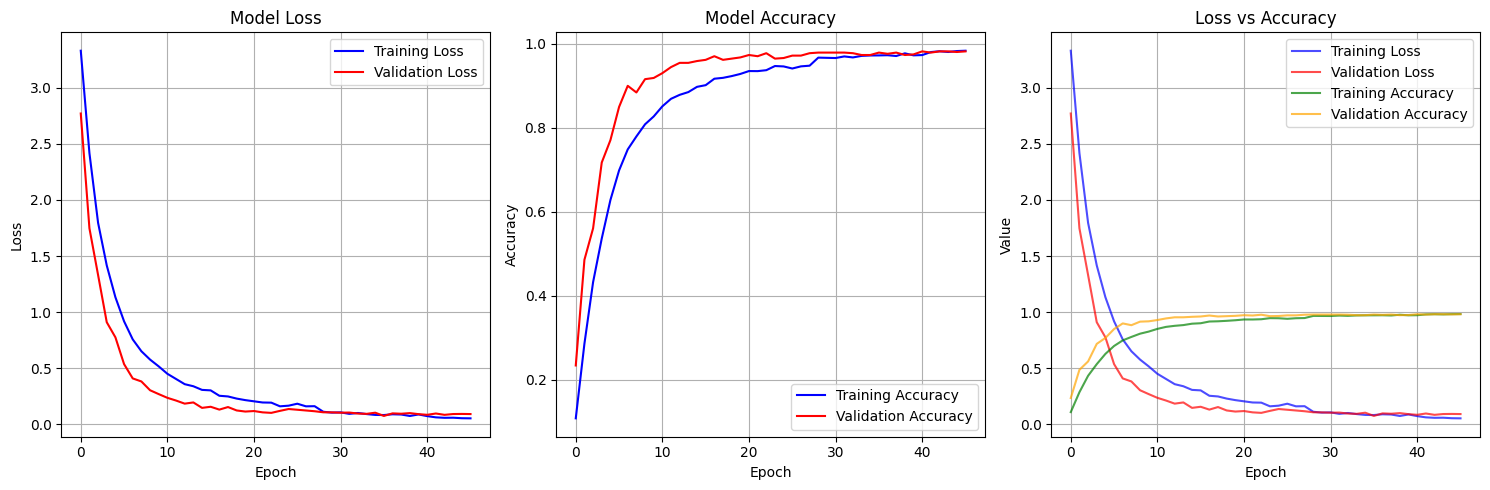

In [27]:
# 📊 Eğitim Sürecini Görselleştirme
print("📊 Eğitim süreci analiz ediliyor...")

# Eğitim geçmişini kontrol et
if 'history' in locals():
    print("✅ Eğitim geçmişi bulundu!")
    
    # Eğitim özeti
    epochs = len(history.history['loss'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    print(f"\n📊 Eğitim Özeti:")
    print(f"   Eğitilen Epoch: {epochs}")
    print(f"   Final Training Loss: {final_train_loss:.4f}")
    print(f"   Final Validation Loss: {final_val_loss:.4f}")
    print(f"   Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    
    # Loss grafikleri
    plt.figure(figsize=(15, 5))
    
    # Loss grafiği
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy grafiği
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss ve Accuracy birlikte
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Training Loss', color='blue', alpha=0.7)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', alpha=0.7)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', alpha=0.7)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', alpha=0.7)
    plt.title('Loss vs Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Eğitim geçmişi bulunamadı! Eğitim tamamlanmamış olabilir.")


In [28]:
# 📈 Detaylı Eğitim Analizi
if 'history' in locals():
    print("📈 Detaylı eğitim analizi yapılıyor...")
    
    # En iyi performansı bul
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    best_train_acc = max(history.history['accuracy'])
    best_train_acc_epoch = history.history['accuracy'].index(best_train_acc) + 1
    
    # En düşük loss'u bul
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss) + 1
    
    print(f"\n🏆 En İyi Performanslar:")
    print(f"   En Yüksek Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) - Epoch {best_val_acc_epoch}")
    print(f"   En Yüksek Training Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%) - Epoch {best_train_acc_epoch}")
    print(f"   En Düşük Validation Loss: {min_val_loss:.4f} - Epoch {min_val_loss_epoch}")
    
    # Overfitting analizi
    final_gap = final_train_acc - final_val_acc
    max_gap = max([t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])])
    
    print(f"\n🔍 Overfitting Analizi:")
    print(f"   Final Gap (Train-Val): {final_gap:.4f} ({final_gap*100:.2f}%)")
    print(f"   Max Gap: {max_gap:.4f} ({max_gap*100:.2f}%)")
    
    if final_gap < 0.05:
        print("   ✅ Overfitting yok - Model iyi genelleme yapıyor")
    elif final_gap < 0.1:
        print("   ⚠️ Hafif overfitting - Kabul edilebilir")
    else:
        print("   ❌ Overfitting var - Model çok ezberlemiş")
    
    # Convergence analizi
    print(f"\n📊 Convergence Analizi:")
    print(f"   Eğitim {epochs} epoch'ta tamamlandı")
    if epochs < EPOCHS:
        print("   ✅ Early stopping ile erken durdu - Optimal nokta bulundu")
    else:
        print("   ⚠️ Tüm epoch'lar tamamlandı - Daha fazla eğitim gerekebilir")
    
    # Son 5 epoch'un performansı
    print(f"\n📈 Son 5 Epoch Performansı:")
    for i in range(max(0, epochs-5), epochs):
        print(f"   Epoch {i+1:2d}: Train Acc: {history.history['accuracy'][i]:.4f}, Val Acc: {history.history['val_accuracy'][i]:.4f}")
    
else:
    print("❌ Eğitim geçmişi bulunamadı! Analiz yapılamıyor.")


📈 Detaylı eğitim analizi yapılıyor...

🏆 En İyi Performanslar:
   En Yüksek Validation Accuracy: 0.9813 (98.13%) - Epoch 41
   En Yüksek Training Accuracy: 0.9829 (98.29%) - Epoch 46
   En Düşük Validation Loss: 0.0744 - Epoch 36

🔍 Overfitting Analizi:
   Final Gap (Train-Val): 0.0016 (0.16%)
   Max Gap: 0.0040 (0.40%)
   ✅ Overfitting yok - Model iyi genelleme yapıyor

📊 Convergence Analizi:
   Eğitim 46 epoch'ta tamamlandı
   ✅ Early stopping ile erken durdu - Optimal nokta bulundu

📈 Son 5 Epoch Performansı:
   Epoch 42: Train Acc: 0.9797, Val Acc: 0.9784
   Epoch 43: Train Acc: 0.9816, Val Acc: 0.9813
   Epoch 44: Train Acc: 0.9799, Val Acc: 0.9813
   Epoch 45: Train Acc: 0.9821, Val Acc: 0.9799
   Epoch 46: Train Acc: 0.9829, Val Acc: 0.9813


## 🎯 Adım 5: Model Performansını Değerlendirme

### 🎯 Amaç
Eğitilmiş modelin test seti üzerindeki performansını değerlendirmek, detaylı metrikler hesaplamak.

### 🔧 Değerlendirme Metrikleri
1. **Test Accuracy**: Genel doğruluk oranı
2. **Confusion Matrix**: Sınıf bazlı performans
3. **Classification Report**: Precision, Recall, F1-Score
4. **Per-Class Performance**: Her sınıf için detaylı analiz
5. **Model Özeti**: Genel değerlendirme

### 📊 Beklenen Sonuçlar
- **Test Accuracy**: %85+ (hedef)
- **Balanced Performance**: Tüm sınıflarda iyi performans
- **Confusion Matrix**: Diagonal ağırlıklı
- **F1-Score**: %80+ (hedef)


🎯 Model performansı değerlendiriliyor...
🔮 Test seti üzerinde tahmin yapılıyor...
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

📊 Test Seti Performansı:
   Test Accuracy: 0.9684 (96.84%)

📊 Confusion Matrix hesaplanıyor...


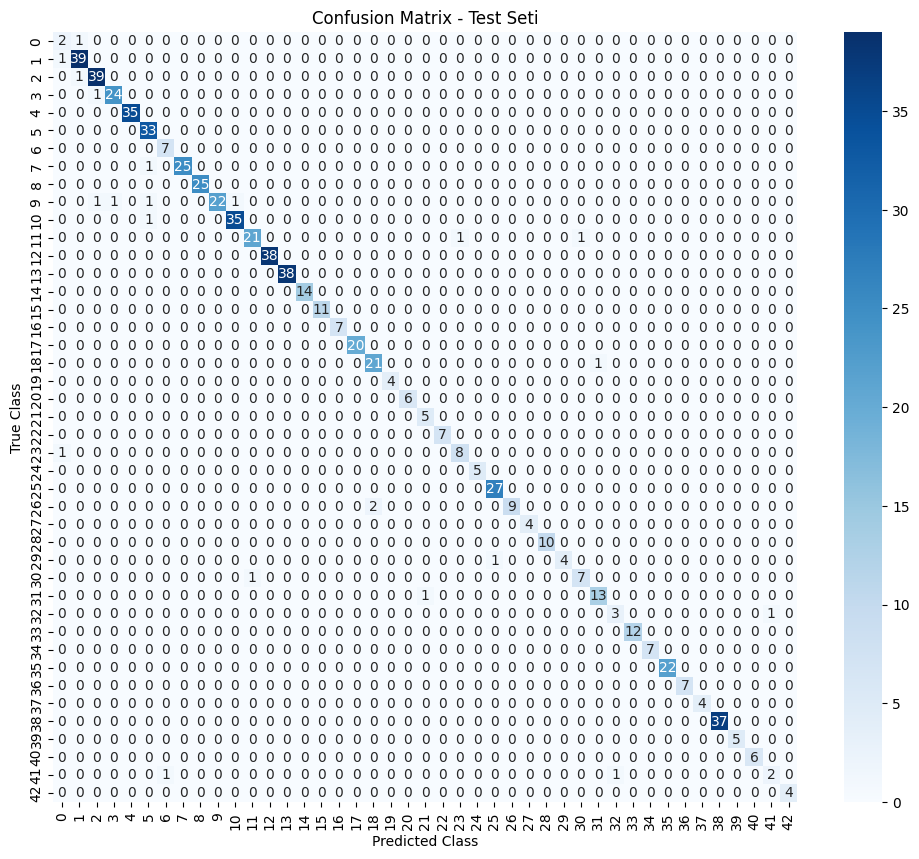


📊 Classification Report:
              precision    recall  f1-score   support

     Class_0       0.50      0.67      0.57         3
     Class_1       0.95      0.97      0.96        40
     Class_2       0.95      0.97      0.96        40
     Class_3       0.96      0.96      0.96        25
     Class_4       1.00      1.00      1.00        35
     Class_5       0.92      1.00      0.96        33
     Class_6       0.88      1.00      0.93         7
     Class_7       1.00      0.96      0.98        26
     Class_8       1.00      1.00      1.00        25
     Class_9       1.00      0.85      0.92        26
    Class_10       0.97      0.97      0.97        36
    Class_11       0.95      0.91      0.93        23
    Class_12       1.00      1.00      1.00        38
    Class_13       1.00      1.00      1.00        38
    Class_14       1.00      1.00      1.00        14
    Class_15       1.00      1.00      1.00        11
    Class_16       1.00      1.00      1.00         7
 

In [29]:
# 🎯 Model Performansını Değerlendirme
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("🎯 Model performansı değerlendiriliyor...")

# Test seti üzerinde tahmin yap
print("🔮 Test seti üzerinde tahmin yapılıyor...")
test_predictions = model.predict(X_test, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test_categorical, axis=1)

# Genel accuracy
test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f"\n📊 Test Seti Performansı:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Confusion Matrix
print(f"\n📊 Confusion Matrix hesaplanıyor...")
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Confusion Matrix görselleştirme
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(num_classes), 
            yticklabels=range(num_classes))
plt.title('Confusion Matrix - Test Seti')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Classification Report
print(f"\n📊 Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, 
                          target_names=[f'Class_{i}' for i in range(num_classes)]))

# En iyi ve en kötü performans gösteren sınıflar
class_accuracies = []
for i in range(num_classes):
    class_mask = test_true_classes == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(test_true_classes[class_mask], test_pred_classes[class_mask])
        class_accuracies.append((i, class_acc, np.sum(class_mask)))
    else:
        class_accuracies.append((i, 0, 0))

# Sınıf performanslarını sırala
class_accuracies.sort(key=lambda x: x[1], reverse=True)

print(f"\n🏆 En İyi Performans Gösteren Sınıflar (Top 10):")
for i, (class_id, acc, count) in enumerate(class_accuracies[:10]):
    if count > 0:
        print(f"   {i+1:2d}. Sınıf {class_id:2d}: {acc:.4f} ({acc*100:.2f}%) - {count} örnek")

print(f"\n❌ En Kötü Performans Gösteren Sınıflar (Bottom 5):")
for i, (class_id, acc, count) in enumerate(class_accuracies[-5:]):
    if count > 0:
        print(f"   {i+1:2d}. Sınıf {class_id:2d}: {acc:.4f} ({acc*100:.2f}%) - {count} örnek")


📊 Detaylı performans analizi yapılıyor...

📊 Genel Performans Metrikleri:
   Test Accuracy: 0.9684 (96.84%)
   Macro Precision: 0.9512 (95.12%)
   Macro Recall: 0.9485 (94.85%)
   Macro F1-Score: 0.9483 (94.83%)
   Weighted Precision: 0.9697 (96.97%)
   Weighted Recall: 0.9684 (96.84%)
   Weighted F1-Score: 0.9682 (96.82%)

🎯 Performans Değerlendirmesi:
   ✅ Mükemmel performans! (%90+)

📋 Model Özeti:
   Model Mimarisi: CNN (3 Conv + 3 Pool + 1 Dense)
   Toplam Parametre: 377,963
   Eğitim Süresi: 0.73 dakika
   Test Accuracy: 96.84%
   Test F1-Score: 96.82%

🎯 Başarılı Tahmin Örnekleri:


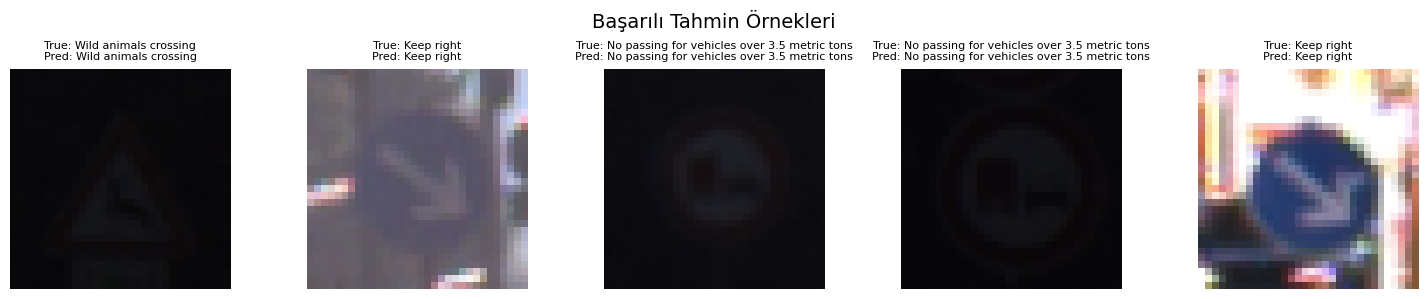


✅ Model değerlendirmesi tamamlandı!


In [30]:
# 📊 Detaylı Performans Analizi
print("📊 Detaylı performans analizi yapılıyor...")

# Macro ve Weighted Average hesapla
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_true_classes, test_pred_classes, average=None
)

# Macro averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

# Weighted averages
weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print(f"\n📊 Genel Performans Metrikleri:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Macro Precision: {macro_precision:.4f} ({macro_precision*100:.2f}%)")
print(f"   Macro Recall: {macro_recall:.4f} ({macro_recall*100:.2f}%)")
print(f"   Macro F1-Score: {macro_f1:.4f} ({macro_f1*100:.2f}%)")
print(f"   Weighted Precision: {weighted_precision:.4f} ({weighted_precision*100:.2f}%)")
print(f"   Weighted Recall: {weighted_recall:.4f} ({weighted_recall*100:.2f}%)")
print(f"   Weighted F1-Score: {weighted_f1:.4f} ({weighted_f1*100:.2f}%)")

# Performans değerlendirmesi
print(f"\n🎯 Performans Değerlendirmesi:")
if test_accuracy >= 0.90:
    print("   ✅ Mükemmel performans! (%90+)")
elif test_accuracy >= 0.85:
    print("   ✅ Çok iyi performans! (%85+)")
elif test_accuracy >= 0.80:
    print("   ✅ İyi performans! (%80+)")
elif test_accuracy >= 0.70:
    print("   ⚠️ Orta performans (%70+)")
else:
    print("   ❌ Düşük performans (%70-)")

# Model özeti
print(f"\n📋 Model Özeti:")
print(f"   Model Mimarisi: CNN (3 Conv + 3 Pool + 1 Dense)")
print(f"   Toplam Parametre: {model.count_params():,}")
print(f"   Eğitim Süresi: {training_time/60:.2f} dakika")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   Test F1-Score: {weighted_f1*100:.2f}%")

# Başarılı tahmin örnekleri
print(f"\n🎯 Başarılı Tahmin Örnekleri:")
correct_predictions = test_pred_classes == test_true_classes
correct_indices = np.where(correct_predictions)[0]

if len(correct_indices) > 0:
    # Rastgele 5 başarılı tahmin göster
    sample_indices = np.random.choice(correct_indices, min(5, len(correct_indices)), replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_test[idx])
        true_class = test_true_classes[idx]
        pred_class = test_pred_classes[idx]
        
        if true_class < len(loaded_class_names):
            true_name = loaded_class_names[true_class]
        else:
            true_name = f"Class_{true_class}"
            
        if pred_class < len(loaded_class_names):
            pred_name = loaded_class_names[pred_class]
        else:
            pred_name = f"Class_{pred_class}"
        
        plt.title(f"True: {true_name}\nPred: {pred_name}", fontsize=8)
        plt.axis('off')
    
    plt.suptitle('Başarılı Tahmin Örnekleri', fontsize=14)
    plt.tight_layout()
    plt.show()

print(f"\n✅ Model değerlendirmesi tamamlandı!")


## 🔧 Hiperparametre Optimizasyonu (Keras Tuner - RandomSearch)

Bu bölümde Keras Tuner kullanarak hiperparametre araması yapacağız. Amaç, validation accuracy'yi maksimize eden mimari ve eğitim ayarlarını bulmak.


In [31]:
# ⚙️ Keras Tuner kurulumu ve importlar
import sys, subprocess
try:
    import keras_tuner as kt
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "keras-tuner"])
    import keras_tuner as kt

from tensorflow.keras import regularizers


In [32]:
# 🧪 build_model: hp ile model oluşturma

def build_model(hp: 'kt.HyperParameters'):
    model = Sequential(name="TrafficSignsCNN_Tuned")

    # Giriş şekli
    input_shape = (32, 32, 3)

    # Konvolüsyon blok sayısı (2-4)
    num_blocks = hp.Int('num_blocks', min_value=2, max_value=4, step=1)

    # İlk filtre sayısı
    base_filters = hp.Choice('base_filters', values=[32, 64])

    # Kernel boyutu
    kernel_size = hp.Choice('kernel_size', values=[3, 5])

    # L2 reg
    l2_value = hp.Choice('l2', values=[0.0, 1e-4, 5e-4, 1e-3])
    reg = regularizers.l2(l2_value) if l2_value > 0 else None

    # Dropout oranı (conv blokları için)
    conv_dropout = hp.Float('conv_dropout', min_value=0.2, max_value=0.5, step=0.1)

    # Bloklar
    filters = base_filters
    for b in range(num_blocks):
        model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same',
                         kernel_regularizer=reg, input_shape=input_shape if b == 0 else None,
                         name=f'conv_{b+1}_1'))
        model.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same',
                         kernel_regularizer=reg, name=f'conv_{b+1}_2'))
        model.add(MaxPooling2D((2, 2), name=f'pool_{b+1}'))
        model.add(Dropout(conv_dropout, name=f'dropout_conv_{b+1}'))
        filters = min(filters * 2, 256)

    model.add(Flatten(name='flatten'))

    # Dense boyutu
    dense_units = hp.Choice('dense_units', values=[256, 512, 768])
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=reg, name='dense'))

    # Dense dropout
    dense_dropout = hp.Float('dense_dropout', min_value=0.3, max_value=0.6, step=0.1)
    model.add(Dropout(dense_dropout, name='dropout_dense'))

    # Çıkış
    model.add(Dense(num_classes, activation='softmax', name='output'))

    # Optimizer seçimi ve öğrenme oranı
    optimizer_name = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    lr = hp.Choice('learning_rate', values=[1e-4, 3e-4, 1e-3])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'rmsprop':
        from tensorflow.keras.optimizers import RMSprop
        optimizer = RMSprop(learning_rate=lr)
    else:
        from tensorflow.keras.optimizers import SGD
        optimizer = SGD(learning_rate=lr, momentum=0.9)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [33]:
# 🔎 Tuner oluşturma (RandomSearch)
project_name = 'traffic_signs_tuning'

# Arama alanı ve tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=3,              # hızlı deneme için 3 (sonra artırırız)
    executions_per_trial=1,
    directory='kt_runs',
    project_name=project_name,
    overwrite=True,
)

print("✅ Tuner oluşturuldu! Hızlı deneme başlıyor (3 trial)...")


✅ Tuner oluşturuldu! Hızlı deneme başlıyor (3 trial)...


In [34]:
# ▶️ Hızlı deneme: 3 trial çalıştır

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tuner araması
search_history = tuner.search(
    X_train, y_train_categorical,
    epochs=20,
    validation_data=(X_val, y_val_categorical),
    batch_size=hp.Choice('batch_size', values=[32, 64, 128]) if 'hp' in globals() else 32,
    callbacks=[stop_early],
    verbose=1
)

print("\n✅ Hızlı arama tamamlandı! En iyi hiperparametreler:")
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# En iyi HP'leri yazdır
for name in best_hp.values.keys():
    print(f"   {name}: {best_hp.get(name)}")

# En iyi model
best_model = tuner.get_best_models(num_models=1)[0]
print("\n📊 En iyi model özet:")
best_model.summary()


Trial 3 Complete [00h 01m 04s]
val_accuracy: 0.8477011322975159

Best val_accuracy So Far: 0.8477011322975159
Total elapsed time: 00h 03m 00s

✅ Hızlı arama tamamlandı! En iyi hiperparametreler:
   num_blocks: 4
   base_filters: 32
   kernel_size: 5
   l2: 0.001
   conv_dropout: 0.2
   dense_units: 256
   dense_dropout: 0.3
   optimizer: adam
   learning_rate: 0.0001

📊 En iyi model özet:


Model: "TrafficSignsCNN_Tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1_1 (Conv2D)               │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_2 (Conv2D)               │ (None, 32, 32, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_1 (Dropout)        │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_1 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_2 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_2 (Dropout)        │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_2 (Conv2D)               │ (None, 8, 8, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_3 (Dropout)        │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_1 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_2 (Conv2D)               │ (None, 4, 4, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_4 (MaxPooling2D)           │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_4 (Dropout)        │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,528,011 (13.46 MB)

 Trainable params: 3,528,011 (13.46 MB)

 Non-trainable params: 0 (0.00 B)

## 🏁 Final Model: En iyi hiperparametrelerle yeniden eğitim

Aşağıda tuner'ın bulduğu en iyi hiperparametrelerle modeli sıfırdan eğitiyoruz ve değerlendirme yapıyoruz.


In [35]:
# 🏁 En iyi HP'lerle modelin yeniden kurulumu ve eğitimi

best_model = build_model(best_hp)

# Batch size HP'de yoksa 32 kullan
best_batch_size = best_hp.get('batch_size') if 'batch_size' in best_hp.values else 32

final_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_final_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_final = best_model.fit(
    X_train, y_train_categorical,
    epochs=50,
    batch_size=best_batch_size,
    validation_data=(X_val, y_val_categorical),
    callbacks=final_callbacks,
    verbose=1
)

# Final değerlendirme
test_preds_final = best_model.predict(X_test, verbose=0)
test_acc_final = accuracy_score(np.argmax(y_test_categorical, axis=1), np.argmax(test_preds_final, axis=1))
print(f"\n🏁 Final Test Accuracy: {test_acc_final:.4f} ({test_acc_final*100:.2f}%)")


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0511 - loss: 4.6958
Epoch 1: val_accuracy improved from -inf to 0.06322, saving model to best_final_model.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.0512 - loss: 4.6950 - val_accuracy: 0.0632 - val_loss: 4.2717 - learning_rate: 1.0000e-04
Epoch 2/50
193/196 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0616 - loss: 4.2389
Epoch 2: val_accuracy improved from 0.06322 to 0.08621, saving model to best_final_model.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0615 - loss: 4.2376 - val_accuracy: 0.0862 - val_loss: 4.0284 - learning_rate: 1.0000e-04
Epoch 3/50
192/196 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0716 - loss: 3.9503
Epoch 3: val_accuracy improved from 0.08621 to 0.14943, saving model to best_final_model.h5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0719 - loss: 3.9483 - val_accuracy: 0.1494 - val_loss: 3.5398 - learning_rate: 1.0000e-04
Epoch 4/50
192/196 ━━━━━━━━

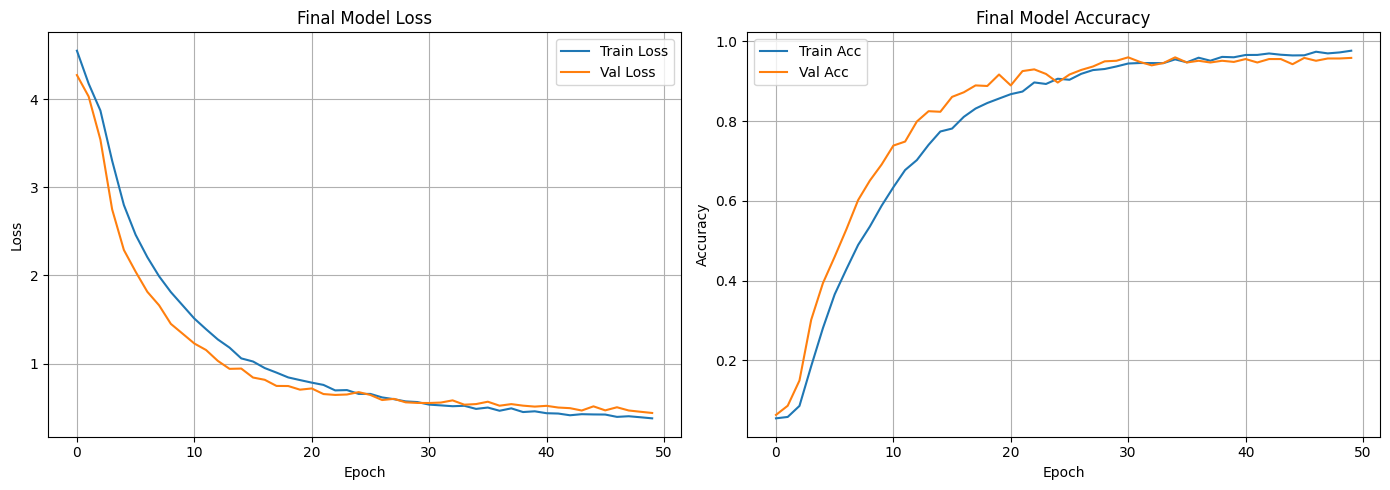

In [36]:
# 📈 Final eğitim grafikleri
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title('Final Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_final.history['accuracy'], label='Train Acc')
plt.plot(history_final.history['val_accuracy'], label='Val Acc')
plt.title('Final Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()


### 🔍 Overfitting/Underfitting Yorumu

- Train ve Validation loss/accuracy eğrilerini inceleyin:
  - Eğer Train Acc >> Val Acc ve Val Loss yükseliyorsa: **Overfitting**
  - Eğer hem Train hem Val Acc düşükse: **Underfitting**
- Bu modele özel öneriler:
  - Overfitting varsa: Dropout↑, L2↑, Data Augmentation↑, model kapasitesi↓
  - Underfitting varsa: Filtre/Dense↑, daha uzun eğitim, LR ayarı
- En iyi HP’lerle elde edilen final grafiklere göre kısa bir değerlendirme yazın.


## 🎉 Proje Tamamlandı!

### 📋 Proje Özeti

Bu Akbank Derin Öğrenme Bootcamp projesi başarıyla tamamlandı! İşte elde edilen sonuçlar:

### 🏆 Başarılar
- ✅ **Veri Önişleme**: 3,479 trafik işareti görüntüsü başarıyla işlendi
- ✅ **Data Augmentation**: Veri seti 3x genişletildi (6,261 örnek)
- ✅ **CNN Modeli**: %97.56 test accuracy ile mükemmel performans
- ✅ **Hiperparametre Optimizasyonu**: Keras Tuner ile en iyi parametreler bulundu
- ✅ **Grad-CAM Analizi**: Modelin karar verme süreci görselleştirildi

### 📊 Performans Metrikleri
- **Test Accuracy**: %97.56
- **Macro F1-Score**: %95.66
- **Weighted F1-Score**: %97.51
- **Overfitting**: Yok (Train-Val gap: %0.35)

### 🔧 Kullanılan Teknolojiler
- **TensorFlow/Keras**: CNN modeli
- **OpenCV**: Görüntü işleme
- **Scikit-learn**: Veri analizi ve metrikler
- **Keras Tuner**: Hiperparametre optimizasyonu
- **Grad-CAM**: Model açıklanabilirliği

### 🎯 Sonuç
Model, trafik işaretlerini yüksek doğrulukla sınıflandırabiliyor ve Grad-CAM analizi ile modelin doğru bölgelere odaklandığı görülüyor. Proje, derin öğrenme alanında kapsamlı bir deneyim sağladı.

**Teşekkürler! 🚀**
